# Основы машинного обучения (ИАД)
## НИУ ВШЭ, 2021-2022 учебный год

### Домашнее задание №8

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

# Бустинг

## Градиентный бустинг своими руками (3 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним **основные формулы**.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$.

> Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.


В качестве функции потерь возьмите **MSE**.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [2]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [257]:
class GradientBoosting:
    def __init__(self, n_estimators=100, max_depth=3, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.trees = []
        self.gammas = []
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
            
        y_current = np.zeros([x.shape[0]])
        
        for i in range(self.n_estimators):
            y_current += self._fit_predict_tree(x, y - y_current)

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        dtr = DecisionTreeRegressor(max_depth=self.max_depth).fit(x, y)
        pred = dtr.predict(x)
        gamma = minimize(lambda w: np.mean(np.square(y - w * pred)),
                        x0=np.array([0.99])).x[0]
        self.gammas.append(gamma)
            
        self.trees.append(dtr)

        return gamma * self.learning_rate * pred
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        y_pred = np.zeros([x.shape[0]]) 
        for i in range(len(self.trees)):
            y_pred += self.gammas[i] * self.learning_rate * self.trees[i].predict(x).reshape([x.shape[0]])
        return y_pred
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
            
        return self
            
    def get_params(self, deep=True):
        return {"n_estimators": self.n_estimators, 
                "max_depth": self.max_depth,
                "learning_rate": self.learning_rate}

Проверьте вашу реализацию на Boston dataset. 

> Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.



In [258]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [259]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [260]:
np.random.seed(19052019)

boosting = GradientBoosting(n_estimators=100, max_depth=3)
boosting.fit(X_train, y_train)
y_pred = boosting.predict(X_test)


In [261]:
mean_squared_error(y_test, y_pred)

12.095473901824775

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да


In [262]:
# Да, реализовал

In [263]:
from sklearn.model_selection import GridSearchCV

In [264]:
params = {
    'n_estimators': range(20, 400, 10),
    'max_depth': range(1, 6),
    'learning_rate': [0.01, 0.1, 0.2, 0.3]
}
gb = GradientBoosting()
gsearch = GridSearchCV(gb,
                       param_grid=params,
                       scoring='neg_mean_squared_error',
                       cv=5,
                       verbose=3)
gsearch.fit(X_train, y_train)
gsearch.best_params_

Fitting 5 folds for each of 760 candidates, totalling 3800 fits
[CV 1/5] END learning_rate=0.01, max_depth=1, n_estimators=20; total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=1, n_estimators=20; total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=1, n_estimators=20; total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=1, n_estimators=20; total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=1, n_estimators=20; total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=1, n_estimators=30; total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=1, n_estimators=30; total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=1, n_estimators=30; total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=1, n_estimators=30; total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=1, n_estimators=30; total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=1, n_estimators=40; total time=   0.1s
[CV 2/5] END learning_rate=0.01, m

[CV 5/5] END learning_rate=0.01, max_depth=1, n_estimators=210; total time=   0.4s
[CV 1/5] END learning_rate=0.01, max_depth=1, n_estimators=220; total time=   0.4s
[CV 2/5] END learning_rate=0.01, max_depth=1, n_estimators=220; total time=   0.4s
[CV 3/5] END learning_rate=0.01, max_depth=1, n_estimators=220; total time=   0.4s
[CV 4/5] END learning_rate=0.01, max_depth=1, n_estimators=220; total time=   0.5s
[CV 5/5] END learning_rate=0.01, max_depth=1, n_estimators=220; total time=   0.4s
[CV 1/5] END learning_rate=0.01, max_depth=1, n_estimators=230; total time=   0.4s
[CV 2/5] END learning_rate=0.01, max_depth=1, n_estimators=230; total time=   0.5s
[CV 3/5] END learning_rate=0.01, max_depth=1, n_estimators=230; total time=   0.5s
[CV 4/5] END learning_rate=0.01, max_depth=1, n_estimators=230; total time=   0.5s
[CV 5/5] END learning_rate=0.01, max_depth=1, n_estimators=230; total time=   0.5s
[CV 1/5] END learning_rate=0.01, max_depth=1, n_estimators=240; total time=   0.5s
[CV 

[CV 4/5] END learning_rate=0.01, max_depth=2, n_estimators=30; total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=2, n_estimators=30; total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=2, n_estimators=40; total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=2, n_estimators=40; total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=2, n_estimators=40; total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=2, n_estimators=40; total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=2, n_estimators=40; total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.1s
[CV 1/5] END lea

[CV 4/5] END learning_rate=0.01, max_depth=2, n_estimators=230; total time=   0.3s
[CV 5/5] END learning_rate=0.01, max_depth=2, n_estimators=230; total time=   0.3s
[CV 1/5] END learning_rate=0.01, max_depth=2, n_estimators=240; total time=   0.3s
[CV 2/5] END learning_rate=0.01, max_depth=2, n_estimators=240; total time=   0.3s
[CV 3/5] END learning_rate=0.01, max_depth=2, n_estimators=240; total time=   0.3s
[CV 4/5] END learning_rate=0.01, max_depth=2, n_estimators=240; total time=   0.3s
[CV 5/5] END learning_rate=0.01, max_depth=2, n_estimators=240; total time=   0.3s
[CV 1/5] END learning_rate=0.01, max_depth=2, n_estimators=250; total time=   0.4s
[CV 2/5] END learning_rate=0.01, max_depth=2, n_estimators=250; total time=   0.4s
[CV 3/5] END learning_rate=0.01, max_depth=2, n_estimators=250; total time=   0.6s
[CV 4/5] END learning_rate=0.01, max_depth=2, n_estimators=250; total time=   0.5s
[CV 5/5] END learning_rate=0.01, max_depth=2, n_estimators=250; total time=   0.5s
[CV 

[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=60; total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=60; total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=60; total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=60; total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=60; total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=70; total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=70; total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=70; total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=70; total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=70; total time=   0.1s
[CV 1/5] END lea

[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=250; total time=   0.6s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=250; total time=   0.6s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=250; total time=   0.6s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=260; total time=   0.6s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=260; total time=   0.6s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=260; total time=   0.6s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=260; total time=   0.6s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=260; total time=   0.6s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=270; total time=   0.6s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=270; total time=   0.6s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=270; total time=   0.6s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=270; total time=   0.6s
[CV 

[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=70; total time=   0.2s
[CV 5/5] END learning_rate=0.01, max_depth=4, n_estimators=70; total time=   0.2s
[CV 1/5] END learning_rate=0.01, max_depth=4, n_estimators=80; total time=   0.2s
[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=80; total time=   0.2s
[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=80; total time=   0.2s
[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=80; total time=   0.2s
[CV 5/5] END learning_rate=0.01, max_depth=4, n_estimators=80; total time=   0.2s
[CV 1/5] END learning_rate=0.01, max_depth=4, n_estimators=90; total time=   0.3s
[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=90; total time=   0.3s
[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=90; total time=   0.3s
[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=90; total time=   0.3s
[CV 5/5] END learning_rate=0.01, max_depth=4, n_estimators=90; total time=   0.3s
[CV 1/5] END lea

[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=270; total time=   0.7s
[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=270; total time=   0.7s
[CV 5/5] END learning_rate=0.01, max_depth=4, n_estimators=270; total time=   0.7s
[CV 1/5] END learning_rate=0.01, max_depth=4, n_estimators=280; total time=   0.8s
[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=280; total time=   0.7s
[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=280; total time=   0.7s
[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=280; total time=   0.7s
[CV 5/5] END learning_rate=0.01, max_depth=4, n_estimators=280; total time=   0.9s
[CV 1/5] END learning_rate=0.01, max_depth=4, n_estimators=290; total time=   0.9s
[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=290; total time=   0.8s
[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=290; total time=   0.8s
[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=290; total time=   0.8s
[CV 

[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=90; total time=   0.3s
[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=90; total time=   0.3s
[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=90; total time=   0.3s
[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.3s
[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.3s
[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.3s
[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.3s
[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.3s
[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=110; total time=   0.3s
[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=110; total time=   0.3s
[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=110; total time=   0.3s
[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=110; total time=   0.3s
[CV 5/5

[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=290; total time=   0.6s
[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=290; total time=   0.6s
[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=290; total time=   0.6s
[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=290; total time=   0.6s
[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=300; total time=   0.6s
[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=300; total time=   0.8s
[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=300; total time=   0.9s
[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=300; total time=   0.9s
[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=300; total time=   0.9s
[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=310; total time=   0.9s
[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=310; total time=   0.9s
[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=310; total time=   0.9s
[CV 

[CV 2/5] END learning_rate=0.1, max_depth=1, n_estimators=110; total time=   0.2s
[CV 3/5] END learning_rate=0.1, max_depth=1, n_estimators=110; total time=   0.2s
[CV 4/5] END learning_rate=0.1, max_depth=1, n_estimators=110; total time=   0.2s
[CV 5/5] END learning_rate=0.1, max_depth=1, n_estimators=110; total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=1, n_estimators=120; total time=   0.2s
[CV 2/5] END learning_rate=0.1, max_depth=1, n_estimators=120; total time=   0.2s
[CV 3/5] END learning_rate=0.1, max_depth=1, n_estimators=120; total time=   0.2s
[CV 4/5] END learning_rate=0.1, max_depth=1, n_estimators=120; total time=   0.3s
[CV 5/5] END learning_rate=0.1, max_depth=1, n_estimators=120; total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=1, n_estimators=130; total time=   0.3s
[CV 2/5] END learning_rate=0.1, max_depth=1, n_estimators=130; total time=   0.2s
[CV 3/5] END learning_rate=0.1, max_depth=1, n_estimators=130; total time=   0.3s
[CV 4/5] END lea

[CV 2/5] END learning_rate=0.1, max_depth=1, n_estimators=310; total time=   0.4s
[CV 3/5] END learning_rate=0.1, max_depth=1, n_estimators=310; total time=   0.4s
[CV 4/5] END learning_rate=0.1, max_depth=1, n_estimators=310; total time=   0.4s
[CV 5/5] END learning_rate=0.1, max_depth=1, n_estimators=310; total time=   0.4s
[CV 1/5] END learning_rate=0.1, max_depth=1, n_estimators=320; total time=   0.4s
[CV 2/5] END learning_rate=0.1, max_depth=1, n_estimators=320; total time=   0.4s
[CV 3/5] END learning_rate=0.1, max_depth=1, n_estimators=320; total time=   0.4s
[CV 4/5] END learning_rate=0.1, max_depth=1, n_estimators=320; total time=   0.4s
[CV 5/5] END learning_rate=0.1, max_depth=1, n_estimators=320; total time=   0.4s
[CV 1/5] END learning_rate=0.1, max_depth=1, n_estimators=330; total time=   0.4s
[CV 2/5] END learning_rate=0.1, max_depth=1, n_estimators=330; total time=   0.4s
[CV 3/5] END learning_rate=0.1, max_depth=1, n_estimators=330; total time=   0.5s
[CV 4/5] END lea

[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=130; total time=   0.3s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=130; total time=   0.3s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=130; total time=   0.3s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=140; total time=   0.3s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=140; total time=   0.3s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=140; total time=   0.4s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=140; total time=   0.3s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=140; total time=   0.3s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=150; total time=   0.4s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=150; total time=   0.4s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=150; total time=   0.4s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=150; total time=   0.4s
[CV 5/5] END lea

[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=330; total time=   0.5s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=330; total time=   0.5s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=330; total time=   0.5s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=340; total time=   0.6s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=340; total time=   0.5s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=340; total time=   0.5s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=340; total time=   0.5s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=340; total time=   0.6s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=350; total time=   0.6s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=350; total time=   0.6s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=350; total time=   0.6s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=350; total time=   0.6s
[CV 5/5] END lea

[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=150; total time=   0.4s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=150; total time=   0.4s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=160; total time=   0.4s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=160; total time=   0.4s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=160; total time=   0.4s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=160; total time=   0.4s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=160; total time=   0.4s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=170; total time=   0.5s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=170; total time=   0.5s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=170; total time=   0.5s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=170; total time=   0.5s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=170; total time=   0.5s
[CV 1/5] END lea

[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=350; total time=   1.1s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=350; total time=   1.0s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=360; total time=   1.1s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=360; total time=   1.1s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=360; total time=   1.1s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=360; total time=   1.1s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=360; total time=   1.1s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=370; total time=   1.2s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=370; total time=   1.1s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=370; total time=   1.1s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=370; total time=   1.2s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=370; total time=   1.1s
[CV 1/5] END lea

[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=170; total time=   0.5s
[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=180; total time=   0.6s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=180; total time=   0.6s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=180; total time=   0.6s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=180; total time=   0.6s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=180; total time=   0.6s
[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=190; total time=   0.6s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=190; total time=   0.6s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=190; total time=   0.6s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=190; total time=   0.6s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=190; total time=   0.6s
[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=200; total time=   0.6s
[CV 2/5] END lea

[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=370; total time=   1.3s
[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=380; total time=   1.3s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=380; total time=   1.2s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=380; total time=   1.2s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=380; total time=   1.2s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=380; total time=   1.2s
[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=390; total time=   1.2s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=390; total time=   1.2s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=390; total time=   1.2s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=390; total time=   1.2s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=390; total time=   1.3s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=20; total time=   0.1s
[CV 2/5] END lear

[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.7s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.7s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.7s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.7s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.7s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=210; total time=   0.7s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=210; total time=   0.7s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=210; total time=   0.7s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=210; total time=   0.7s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=210; total time=   0.5s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=220; total time=   0.5s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=220; total time=   0.5s
[CV 3/5] END lea

[CV 3/5] END learning_rate=0.2, max_depth=1, n_estimators=30; total time=   0.0s
[CV 4/5] END learning_rate=0.2, max_depth=1, n_estimators=30; total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=1, n_estimators=30; total time=   0.0s
[CV 1/5] END learning_rate=0.2, max_depth=1, n_estimators=40; total time=   0.0s
[CV 2/5] END learning_rate=0.2, max_depth=1, n_estimators=40; total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=1, n_estimators=40; total time=   0.0s
[CV 4/5] END learning_rate=0.2, max_depth=1, n_estimators=40; total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=1, n_estimators=40; total time=   0.0s
[CV 1/5] END learning_rate=0.2, max_depth=1, n_estimators=50; total time=   0.1s
[CV 2/5] END learning_rate=0.2, max_depth=1, n_estimators=50; total time=   0.1s
[CV 3/5] END learning_rate=0.2, max_depth=1, n_estimators=50; total time=   0.1s
[CV 4/5] END learning_rate=0.2, max_depth=1, n_estimators=50; total time=   0.1s
[CV 5/5] END learning_rate=0

[CV 4/5] END learning_rate=0.2, max_depth=1, n_estimators=230; total time=   0.6s
[CV 5/5] END learning_rate=0.2, max_depth=1, n_estimators=230; total time=   0.5s
[CV 1/5] END learning_rate=0.2, max_depth=1, n_estimators=240; total time=   0.6s
[CV 2/5] END learning_rate=0.2, max_depth=1, n_estimators=240; total time=   0.6s
[CV 3/5] END learning_rate=0.2, max_depth=1, n_estimators=240; total time=   0.6s
[CV 4/5] END learning_rate=0.2, max_depth=1, n_estimators=240; total time=   0.5s
[CV 5/5] END learning_rate=0.2, max_depth=1, n_estimators=240; total time=   0.6s
[CV 1/5] END learning_rate=0.2, max_depth=1, n_estimators=250; total time=   0.6s
[CV 2/5] END learning_rate=0.2, max_depth=1, n_estimators=250; total time=   0.6s
[CV 3/5] END learning_rate=0.2, max_depth=1, n_estimators=250; total time=   0.7s
[CV 4/5] END learning_rate=0.2, max_depth=1, n_estimators=250; total time=   0.7s
[CV 5/5] END learning_rate=0.2, max_depth=1, n_estimators=250; total time=   0.6s
[CV 1/5] END lea

[CV 5/5] END learning_rate=0.2, max_depth=2, n_estimators=50; total time=   0.1s
[CV 1/5] END learning_rate=0.2, max_depth=2, n_estimators=60; total time=   0.1s
[CV 2/5] END learning_rate=0.2, max_depth=2, n_estimators=60; total time=   0.1s
[CV 3/5] END learning_rate=0.2, max_depth=2, n_estimators=60; total time=   0.1s
[CV 4/5] END learning_rate=0.2, max_depth=2, n_estimators=60; total time=   0.1s
[CV 5/5] END learning_rate=0.2, max_depth=2, n_estimators=60; total time=   0.1s
[CV 1/5] END learning_rate=0.2, max_depth=2, n_estimators=70; total time=   0.1s
[CV 2/5] END learning_rate=0.2, max_depth=2, n_estimators=70; total time=   0.1s
[CV 3/5] END learning_rate=0.2, max_depth=2, n_estimators=70; total time=   0.1s
[CV 4/5] END learning_rate=0.2, max_depth=2, n_estimators=70; total time=   0.1s
[CV 5/5] END learning_rate=0.2, max_depth=2, n_estimators=70; total time=   0.1s
[CV 1/5] END learning_rate=0.2, max_depth=2, n_estimators=80; total time=   0.2s
[CV 2/5] END learning_rate=0

[CV 1/5] END learning_rate=0.2, max_depth=2, n_estimators=260; total time=   0.4s
[CV 2/5] END learning_rate=0.2, max_depth=2, n_estimators=260; total time=   0.4s
[CV 3/5] END learning_rate=0.2, max_depth=2, n_estimators=260; total time=   0.4s
[CV 4/5] END learning_rate=0.2, max_depth=2, n_estimators=260; total time=   0.4s
[CV 5/5] END learning_rate=0.2, max_depth=2, n_estimators=260; total time=   0.4s
[CV 1/5] END learning_rate=0.2, max_depth=2, n_estimators=270; total time=   0.4s
[CV 2/5] END learning_rate=0.2, max_depth=2, n_estimators=270; total time=   0.5s
[CV 3/5] END learning_rate=0.2, max_depth=2, n_estimators=270; total time=   0.5s
[CV 4/5] END learning_rate=0.2, max_depth=2, n_estimators=270; total time=   0.4s
[CV 5/5] END learning_rate=0.2, max_depth=2, n_estimators=270; total time=   0.5s
[CV 1/5] END learning_rate=0.2, max_depth=2, n_estimators=280; total time=   0.5s
[CV 2/5] END learning_rate=0.2, max_depth=2, n_estimators=280; total time=   0.5s
[CV 3/5] END lea

[CV 2/5] END learning_rate=0.2, max_depth=3, n_estimators=80; total time=   0.1s
[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=80; total time=   0.1s
[CV 4/5] END learning_rate=0.2, max_depth=3, n_estimators=80; total time=   0.1s
[CV 5/5] END learning_rate=0.2, max_depth=3, n_estimators=80; total time=   0.1s
[CV 1/5] END learning_rate=0.2, max_depth=3, n_estimators=90; total time=   0.2s
[CV 2/5] END learning_rate=0.2, max_depth=3, n_estimators=90; total time=   0.2s
[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=90; total time=   0.2s
[CV 4/5] END learning_rate=0.2, max_depth=3, n_estimators=90; total time=   0.2s
[CV 5/5] END learning_rate=0.2, max_depth=3, n_estimators=90; total time=   0.2s
[CV 1/5] END learning_rate=0.2, max_depth=3, n_estimators=100; total time=   0.2s
[CV 2/5] END learning_rate=0.2, max_depth=3, n_estimators=100; total time=   0.2s
[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=100; total time=   0.2s
[CV 4/5] END learning_rat

[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=280; total time=   0.9s
[CV 4/5] END learning_rate=0.2, max_depth=3, n_estimators=280; total time=   0.8s
[CV 5/5] END learning_rate=0.2, max_depth=3, n_estimators=280; total time=   0.9s
[CV 1/5] END learning_rate=0.2, max_depth=3, n_estimators=290; total time=   0.9s
[CV 2/5] END learning_rate=0.2, max_depth=3, n_estimators=290; total time=   0.9s
[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=290; total time=   0.9s
[CV 4/5] END learning_rate=0.2, max_depth=3, n_estimators=290; total time=   0.9s
[CV 5/5] END learning_rate=0.2, max_depth=3, n_estimators=290; total time=   0.9s
[CV 1/5] END learning_rate=0.2, max_depth=3, n_estimators=300; total time=   0.9s
[CV 2/5] END learning_rate=0.2, max_depth=3, n_estimators=300; total time=   0.7s
[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=300; total time=   0.6s
[CV 4/5] END learning_rate=0.2, max_depth=3, n_estimators=300; total time=   0.6s
[CV 5/5] END lea

[CV 4/5] END learning_rate=0.2, max_depth=4, n_estimators=100; total time=   0.3s
[CV 5/5] END learning_rate=0.2, max_depth=4, n_estimators=100; total time=   0.3s
[CV 1/5] END learning_rate=0.2, max_depth=4, n_estimators=110; total time=   0.4s
[CV 2/5] END learning_rate=0.2, max_depth=4, n_estimators=110; total time=   0.4s
[CV 3/5] END learning_rate=0.2, max_depth=4, n_estimators=110; total time=   0.4s
[CV 4/5] END learning_rate=0.2, max_depth=4, n_estimators=110; total time=   0.4s
[CV 5/5] END learning_rate=0.2, max_depth=4, n_estimators=110; total time=   0.4s
[CV 1/5] END learning_rate=0.2, max_depth=4, n_estimators=120; total time=   0.4s
[CV 2/5] END learning_rate=0.2, max_depth=4, n_estimators=120; total time=   0.4s
[CV 3/5] END learning_rate=0.2, max_depth=4, n_estimators=120; total time=   0.4s
[CV 4/5] END learning_rate=0.2, max_depth=4, n_estimators=120; total time=   0.4s
[CV 5/5] END learning_rate=0.2, max_depth=4, n_estimators=120; total time=   0.4s
[CV 1/5] END lea

[CV 4/5] END learning_rate=0.2, max_depth=4, n_estimators=300; total time=   0.5s
[CV 5/5] END learning_rate=0.2, max_depth=4, n_estimators=300; total time=   0.5s
[CV 1/5] END learning_rate=0.2, max_depth=4, n_estimators=310; total time=   0.5s
[CV 2/5] END learning_rate=0.2, max_depth=4, n_estimators=310; total time=   0.5s
[CV 3/5] END learning_rate=0.2, max_depth=4, n_estimators=310; total time=   0.5s
[CV 4/5] END learning_rate=0.2, max_depth=4, n_estimators=310; total time=   0.5s
[CV 5/5] END learning_rate=0.2, max_depth=4, n_estimators=310; total time=   0.5s
[CV 1/5] END learning_rate=0.2, max_depth=4, n_estimators=320; total time=   0.8s
[CV 2/5] END learning_rate=0.2, max_depth=4, n_estimators=320; total time=   0.9s
[CV 3/5] END learning_rate=0.2, max_depth=4, n_estimators=320; total time=   0.9s
[CV 4/5] END learning_rate=0.2, max_depth=4, n_estimators=320; total time=   0.9s
[CV 5/5] END learning_rate=0.2, max_depth=4, n_estimators=320; total time=   0.9s
[CV 1/5] END lea

[CV 5/5] END learning_rate=0.2, max_depth=5, n_estimators=120; total time=   0.4s
[CV 1/5] END learning_rate=0.2, max_depth=5, n_estimators=130; total time=   0.4s
[CV 2/5] END learning_rate=0.2, max_depth=5, n_estimators=130; total time=   0.4s
[CV 3/5] END learning_rate=0.2, max_depth=5, n_estimators=130; total time=   0.4s
[CV 4/5] END learning_rate=0.2, max_depth=5, n_estimators=130; total time=   0.5s
[CV 5/5] END learning_rate=0.2, max_depth=5, n_estimators=130; total time=   0.4s
[CV 1/5] END learning_rate=0.2, max_depth=5, n_estimators=140; total time=   0.5s
[CV 2/5] END learning_rate=0.2, max_depth=5, n_estimators=140; total time=   0.5s
[CV 3/5] END learning_rate=0.2, max_depth=5, n_estimators=140; total time=   0.5s
[CV 4/5] END learning_rate=0.2, max_depth=5, n_estimators=140; total time=   0.5s
[CV 5/5] END learning_rate=0.2, max_depth=5, n_estimators=140; total time=   0.5s
[CV 1/5] END learning_rate=0.2, max_depth=5, n_estimators=150; total time=   0.5s
[CV 2/5] END lea

[CV 5/5] END learning_rate=0.2, max_depth=5, n_estimators=320; total time=   0.8s
[CV 1/5] END learning_rate=0.2, max_depth=5, n_estimators=330; total time=   0.7s
[CV 2/5] END learning_rate=0.2, max_depth=5, n_estimators=330; total time=   0.6s
[CV 3/5] END learning_rate=0.2, max_depth=5, n_estimators=330; total time=   0.5s
[CV 4/5] END learning_rate=0.2, max_depth=5, n_estimators=330; total time=   0.6s
[CV 5/5] END learning_rate=0.2, max_depth=5, n_estimators=330; total time=   0.6s
[CV 1/5] END learning_rate=0.2, max_depth=5, n_estimators=340; total time=   0.6s
[CV 2/5] END learning_rate=0.2, max_depth=5, n_estimators=340; total time=   0.6s
[CV 3/5] END learning_rate=0.2, max_depth=5, n_estimators=340; total time=   0.6s
[CV 4/5] END learning_rate=0.2, max_depth=5, n_estimators=340; total time=   0.9s
[CV 5/5] END learning_rate=0.2, max_depth=5, n_estimators=340; total time=   0.9s
[CV 1/5] END learning_rate=0.2, max_depth=5, n_estimators=350; total time=   0.9s
[CV 2/5] END lea

[CV 1/5] END learning_rate=0.3, max_depth=1, n_estimators=150; total time=   0.3s
[CV 2/5] END learning_rate=0.3, max_depth=1, n_estimators=150; total time=   0.3s
[CV 3/5] END learning_rate=0.3, max_depth=1, n_estimators=150; total time=   0.4s
[CV 4/5] END learning_rate=0.3, max_depth=1, n_estimators=150; total time=   0.3s
[CV 5/5] END learning_rate=0.3, max_depth=1, n_estimators=150; total time=   0.3s
[CV 1/5] END learning_rate=0.3, max_depth=1, n_estimators=160; total time=   0.4s
[CV 2/5] END learning_rate=0.3, max_depth=1, n_estimators=160; total time=   0.4s
[CV 3/5] END learning_rate=0.3, max_depth=1, n_estimators=160; total time=   0.4s
[CV 4/5] END learning_rate=0.3, max_depth=1, n_estimators=160; total time=   0.4s
[CV 5/5] END learning_rate=0.3, max_depth=1, n_estimators=160; total time=   0.4s
[CV 1/5] END learning_rate=0.3, max_depth=1, n_estimators=170; total time=   0.4s
[CV 2/5] END learning_rate=0.3, max_depth=1, n_estimators=170; total time=   0.4s
[CV 3/5] END lea

[CV 1/5] END learning_rate=0.3, max_depth=1, n_estimators=350; total time=   0.9s
[CV 2/5] END learning_rate=0.3, max_depth=1, n_estimators=350; total time=   0.9s
[CV 3/5] END learning_rate=0.3, max_depth=1, n_estimators=350; total time=   0.9s
[CV 4/5] END learning_rate=0.3, max_depth=1, n_estimators=350; total time=   0.9s
[CV 5/5] END learning_rate=0.3, max_depth=1, n_estimators=350; total time=   0.9s
[CV 1/5] END learning_rate=0.3, max_depth=1, n_estimators=360; total time=   0.9s
[CV 2/5] END learning_rate=0.3, max_depth=1, n_estimators=360; total time=   0.9s
[CV 3/5] END learning_rate=0.3, max_depth=1, n_estimators=360; total time=   0.9s
[CV 4/5] END learning_rate=0.3, max_depth=1, n_estimators=360; total time=   0.9s
[CV 5/5] END learning_rate=0.3, max_depth=1, n_estimators=360; total time=   0.9s
[CV 1/5] END learning_rate=0.3, max_depth=1, n_estimators=370; total time=   0.8s
[CV 2/5] END learning_rate=0.3, max_depth=1, n_estimators=370; total time=   0.6s
[CV 3/5] END lea

[CV 2/5] END learning_rate=0.3, max_depth=2, n_estimators=170; total time=   0.4s
[CV 3/5] END learning_rate=0.3, max_depth=2, n_estimators=170; total time=   0.4s
[CV 4/5] END learning_rate=0.3, max_depth=2, n_estimators=170; total time=   0.4s
[CV 5/5] END learning_rate=0.3, max_depth=2, n_estimators=170; total time=   0.3s
[CV 1/5] END learning_rate=0.3, max_depth=2, n_estimators=180; total time=   0.3s
[CV 2/5] END learning_rate=0.3, max_depth=2, n_estimators=180; total time=   0.3s
[CV 3/5] END learning_rate=0.3, max_depth=2, n_estimators=180; total time=   0.3s
[CV 4/5] END learning_rate=0.3, max_depth=2, n_estimators=180; total time=   0.3s
[CV 5/5] END learning_rate=0.3, max_depth=2, n_estimators=180; total time=   0.3s
[CV 1/5] END learning_rate=0.3, max_depth=2, n_estimators=190; total time=   0.3s
[CV 2/5] END learning_rate=0.3, max_depth=2, n_estimators=190; total time=   0.3s
[CV 3/5] END learning_rate=0.3, max_depth=2, n_estimators=190; total time=   0.3s
[CV 4/5] END lea

[CV 2/5] END learning_rate=0.3, max_depth=2, n_estimators=370; total time=   1.1s
[CV 3/5] END learning_rate=0.3, max_depth=2, n_estimators=370; total time=   1.1s
[CV 4/5] END learning_rate=0.3, max_depth=2, n_estimators=370; total time=   1.1s
[CV 5/5] END learning_rate=0.3, max_depth=2, n_estimators=370; total time=   1.0s
[CV 1/5] END learning_rate=0.3, max_depth=2, n_estimators=380; total time=   1.1s
[CV 2/5] END learning_rate=0.3, max_depth=2, n_estimators=380; total time=   1.1s
[CV 3/5] END learning_rate=0.3, max_depth=2, n_estimators=380; total time=   1.1s
[CV 4/5] END learning_rate=0.3, max_depth=2, n_estimators=380; total time=   1.1s
[CV 5/5] END learning_rate=0.3, max_depth=2, n_estimators=380; total time=   1.1s
[CV 1/5] END learning_rate=0.3, max_depth=2, n_estimators=390; total time=   1.0s
[CV 2/5] END learning_rate=0.3, max_depth=2, n_estimators=390; total time=   1.0s
[CV 3/5] END learning_rate=0.3, max_depth=2, n_estimators=390; total time=   1.1s
[CV 4/5] END lea

[CV 3/5] END learning_rate=0.3, max_depth=3, n_estimators=190; total time=   0.4s
[CV 4/5] END learning_rate=0.3, max_depth=3, n_estimators=190; total time=   0.4s
[CV 5/5] END learning_rate=0.3, max_depth=3, n_estimators=190; total time=   0.4s
[CV 1/5] END learning_rate=0.3, max_depth=3, n_estimators=200; total time=   0.4s
[CV 2/5] END learning_rate=0.3, max_depth=3, n_estimators=200; total time=   0.4s
[CV 3/5] END learning_rate=0.3, max_depth=3, n_estimators=200; total time=   0.4s
[CV 4/5] END learning_rate=0.3, max_depth=3, n_estimators=200; total time=   0.8s
[CV 5/5] END learning_rate=0.3, max_depth=3, n_estimators=200; total time=   0.7s
[CV 1/5] END learning_rate=0.3, max_depth=3, n_estimators=210; total time=   0.6s
[CV 2/5] END learning_rate=0.3, max_depth=3, n_estimators=210; total time=   0.6s
[CV 3/5] END learning_rate=0.3, max_depth=3, n_estimators=210; total time=   0.6s
[CV 4/5] END learning_rate=0.3, max_depth=3, n_estimators=210; total time=   0.6s
[CV 5/5] END lea

[CV 3/5] END learning_rate=0.3, max_depth=3, n_estimators=390; total time=   0.9s
[CV 4/5] END learning_rate=0.3, max_depth=3, n_estimators=390; total time=   1.0s
[CV 5/5] END learning_rate=0.3, max_depth=3, n_estimators=390; total time=   1.0s
[CV 1/5] END learning_rate=0.3, max_depth=4, n_estimators=20; total time=   0.1s
[CV 2/5] END learning_rate=0.3, max_depth=4, n_estimators=20; total time=   0.1s
[CV 3/5] END learning_rate=0.3, max_depth=4, n_estimators=20; total time=   0.1s
[CV 4/5] END learning_rate=0.3, max_depth=4, n_estimators=20; total time=   0.1s
[CV 5/5] END learning_rate=0.3, max_depth=4, n_estimators=20; total time=   0.1s
[CV 1/5] END learning_rate=0.3, max_depth=4, n_estimators=30; total time=   0.1s
[CV 2/5] END learning_rate=0.3, max_depth=4, n_estimators=30; total time=   0.1s
[CV 3/5] END learning_rate=0.3, max_depth=4, n_estimators=30; total time=   0.1s
[CV 4/5] END learning_rate=0.3, max_depth=4, n_estimators=30; total time=   0.1s
[CV 5/5] END learning_rat

[CV 4/5] END learning_rate=0.3, max_depth=4, n_estimators=210; total time=   0.6s
[CV 5/5] END learning_rate=0.3, max_depth=4, n_estimators=210; total time=   0.6s
[CV 1/5] END learning_rate=0.3, max_depth=4, n_estimators=220; total time=   0.6s
[CV 2/5] END learning_rate=0.3, max_depth=4, n_estimators=220; total time=   0.6s
[CV 3/5] END learning_rate=0.3, max_depth=4, n_estimators=220; total time=   0.5s
[CV 4/5] END learning_rate=0.3, max_depth=4, n_estimators=220; total time=   0.4s
[CV 5/5] END learning_rate=0.3, max_depth=4, n_estimators=220; total time=   0.4s
[CV 1/5] END learning_rate=0.3, max_depth=4, n_estimators=230; total time=   0.4s
[CV 2/5] END learning_rate=0.3, max_depth=4, n_estimators=230; total time=   0.4s
[CV 3/5] END learning_rate=0.3, max_depth=4, n_estimators=230; total time=   0.4s
[CV 4/5] END learning_rate=0.3, max_depth=4, n_estimators=230; total time=   0.5s
[CV 5/5] END learning_rate=0.3, max_depth=4, n_estimators=230; total time=   0.6s
[CV 1/5] END lea

[CV 5/5] END learning_rate=0.3, max_depth=5, n_estimators=30; total time=   0.1s
[CV 1/5] END learning_rate=0.3, max_depth=5, n_estimators=40; total time=   0.1s
[CV 2/5] END learning_rate=0.3, max_depth=5, n_estimators=40; total time=   0.1s
[CV 3/5] END learning_rate=0.3, max_depth=5, n_estimators=40; total time=   0.1s
[CV 4/5] END learning_rate=0.3, max_depth=5, n_estimators=40; total time=   0.1s
[CV 5/5] END learning_rate=0.3, max_depth=5, n_estimators=40; total time=   0.1s
[CV 1/5] END learning_rate=0.3, max_depth=5, n_estimators=50; total time=   0.2s
[CV 2/5] END learning_rate=0.3, max_depth=5, n_estimators=50; total time=   0.2s
[CV 3/5] END learning_rate=0.3, max_depth=5, n_estimators=50; total time=   0.2s
[CV 4/5] END learning_rate=0.3, max_depth=5, n_estimators=50; total time=   0.2s
[CV 5/5] END learning_rate=0.3, max_depth=5, n_estimators=50; total time=   0.2s
[CV 1/5] END learning_rate=0.3, max_depth=5, n_estimators=60; total time=   0.2s
[CV 2/5] END learning_rate=0

[CV 1/5] END learning_rate=0.3, max_depth=5, n_estimators=240; total time=   0.4s
[CV 2/5] END learning_rate=0.3, max_depth=5, n_estimators=240; total time=   0.5s
[CV 3/5] END learning_rate=0.3, max_depth=5, n_estimators=240; total time=   0.6s
[CV 4/5] END learning_rate=0.3, max_depth=5, n_estimators=240; total time=   0.6s
[CV 5/5] END learning_rate=0.3, max_depth=5, n_estimators=240; total time=   0.6s
[CV 1/5] END learning_rate=0.3, max_depth=5, n_estimators=250; total time=   0.7s
[CV 2/5] END learning_rate=0.3, max_depth=5, n_estimators=250; total time=   0.7s
[CV 3/5] END learning_rate=0.3, max_depth=5, n_estimators=250; total time=   0.7s
[CV 4/5] END learning_rate=0.3, max_depth=5, n_estimators=250; total time=   0.7s
[CV 5/5] END learning_rate=0.3, max_depth=5, n_estimators=250; total time=   0.7s
[CV 1/5] END learning_rate=0.3, max_depth=5, n_estimators=260; total time=   0.7s
[CV 2/5] END learning_rate=0.3, max_depth=5, n_estimators=260; total time=   0.7s
[CV 3/5] END lea

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 120}

In [265]:
boosting = GradientBoosting(n_estimators=120, max_depth=3)
boosting.fit(X_train, y_train)
y_pred = boosting.predict(X_test)
mean_squared_error(y_test, y_pred)

11.946425241500664

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {`XGboost`, `catboost`, `LightGBM`} и `GridSearchCV` для достижения результата.

> Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.



In [3]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

In [4]:
train.head()

Month DayofMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance  \
0   c-8       c-21       c-7     1934            AA    ATL  DFW       732   
1   c-4       c-20       c-3     1548            US    PIT  MCO       834   
2   c-9        c-2       c-5     1422            XE    RDU  CLE       416   
3  c-11       c-25       c-6     1015            OO    DEN  MEM       872   
4  c-10        c-7       c-6     1828            WN    MDW  OMA       423   

  dep_delayed_15min  
0                 N  
1                 N  
2                 N  
3                 N  
4                 Y

In [5]:
# Референс
from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

0.7051631421669804

In [267]:
!pip install xgboost

     |████████████████████████████████| 192.9 MB 130 kB/s eta 0:00:01     |█████████████████████▍          | 129.1 MB 3.5 MB/s eta 0:00:19


In [318]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [319]:
for feature in ['Month', 'DayofMonth', 'DayOfWeek', 'Origin', 'Dest']:
    res = encode_and_bind(train, feature)
    
res

Month DayofMonth DayOfWeek  DepTime UniqueCarrier Origin  Distance  \
0       c-8       c-21       c-7     1934            AA    ATL       732   
1       c-4       c-20       c-3     1548            US    PIT       834   
2       c-9        c-2       c-5     1422            XE    RDU       416   
3      c-11       c-25       c-6     1015            OO    DEN       872   
4      c-10        c-7       c-6     1828            WN    MDW       423   
...     ...        ...       ...      ...           ...    ...       ...   
99995   c-5        c-4       c-3     1618            OO    SFO       199   
99996   c-1       c-18       c-3      804            CO    EWR       884   
99997   c-1       c-24       c-2     1901            NW    DTW      1076   
99998   c-4       c-27       c-4     1515            MQ    DFW       140   
99999  c-11       c-17       c-4     1800            WN    SEA       605   

      dep_delayed_15min  Dest_ABE  Dest_ABI  ...  Dest_TYS  Dest_VCT  \
0                     N         0         0  ...         0         0   
1                     N         0         0  ...         0         0   
2                     N         0         0  ...         0         0   
3                     N         0         0  ...         0         0   
4                     Y         0         0  ...         0         0   
...                 ...       ...       ...  ...       ...       ...   
99995                 N         0         0  ...         0         0   
99996                 N         0         0  ...         0         0   
99997                 N         0         0  ...         0         0   
99998                 N         0         0  ...         0         0   
99999                 N         0         0  ...         0         0   

       Dest_VIS  Dest_VLD  Dest_VPS  Dest_WRG  Dest_WYS  Dest_XNA  Dest_YAK  \
0             0         0         0         0         0         0         0   
1             0         0         0         0         0         0         0   
2             0         0         0         0         0         0         0   
3             0         0         0         0         0         0         0   
4             0         0         0         0         0         0         0   
...         ...       ...       ...       ...       ...       ...       ...   
99995         0         0         0         0         0         0         0   
99996         0         0         0         0         0         0         0   
99997         0         0         0         0         0         0         0   
99998         0         0         0         0         0         0         0   
99999         0         0         0         0         0         0         0   

       Dest_YUM  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
99995         0  
99996         0  
99997         0  
99998         0  
99999         0  

[100000 rows x 297 columns]

In [320]:
res = res.drop(columns=['Month', 'DayofMonth', 'DayOfWeek', 'Origin', 'UniqueCarrier'])

In [321]:
X = res.drop(columns=['dep_delayed_15min'])
y = res['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

In [322]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X, y, test_size=0.3)

In [324]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 199 kB/s eta 0:00:01
     |████████████████████████████████| 15.2 MB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 46 kB 1.9 MB/s eta 0:00:01


In [51]:
# Выше я пытался работать с XGBClassifier, закоировав категориальный признаки как one-hot-encoding. 
# Теперь буду использовать catboost, он сам умеет кодировать категориальные признаки
from catboost import CatBoostClassifier

In [325]:
features = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest']
X_train = train.drop(labels='dep_delayed_15min', axis=1)
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

In [328]:
cbc = CatBoostClassifier(task_type='CPU')
cbc.fit(X_train_part, y_train_part, cat_features=features)

Learning rate set to 0.063211
0:	learn: 0.6593428	total: 85ms	remaining: 1m 24s
1:	learn: 0.6322884	total: 103ms	remaining: 51.5s
2:	learn: 0.6073053	total: 129ms	remaining: 42.8s
3:	learn: 0.5874704	total: 149ms	remaining: 37s
4:	learn: 0.5687677	total: 181ms	remaining: 36s
5:	learn: 0.5545885	total: 211ms	remaining: 35s
6:	learn: 0.5417549	total: 242ms	remaining: 34.4s
7:	learn: 0.5308655	total: 260ms	remaining: 32.3s
8:	learn: 0.5211425	total: 298ms	remaining: 32.8s
9:	learn: 0.5122607	total: 321ms	remaining: 31.7s
10:	learn: 0.5055052	total: 335ms	remaining: 30.1s
11:	learn: 0.4981572	total: 368ms	remaining: 30.3s
12:	learn: 0.4921417	total: 397ms	remaining: 30.1s
13:	learn: 0.4865296	total: 431ms	remaining: 30.4s
14:	learn: 0.4827807	total: 450ms	remaining: 29.6s
15:	learn: 0.4795332	total: 466ms	remaining: 28.7s
16:	learn: 0.4748862	total: 516ms	remaining: 29.8s
17:	learn: 0.4711360	total: 550ms	remaining: 30s
18:	learn: 0.4681401	total: 586ms	remaining: 30.3s
19:	learn: 0.465436

164:	learn: 0.4200469	total: 7.1s	remaining: 35.9s
165:	learn: 0.4199930	total: 7.15s	remaining: 35.9s
166:	learn: 0.4199355	total: 7.22s	remaining: 36s
167:	learn: 0.4199128	total: 7.26s	remaining: 35.9s
168:	learn: 0.4198692	total: 7.31s	remaining: 36s
169:	learn: 0.4198030	total: 7.36s	remaining: 35.9s
170:	learn: 0.4197343	total: 7.41s	remaining: 35.9s
171:	learn: 0.4196172	total: 7.46s	remaining: 35.9s
172:	learn: 0.4195804	total: 7.51s	remaining: 35.9s
173:	learn: 0.4195267	total: 7.58s	remaining: 36s
174:	learn: 0.4193831	total: 7.63s	remaining: 36s
175:	learn: 0.4192636	total: 7.68s	remaining: 36s
176:	learn: 0.4191798	total: 7.73s	remaining: 35.9s
177:	learn: 0.4191084	total: 7.77s	remaining: 35.9s
178:	learn: 0.4190648	total: 7.8s	remaining: 35.8s
179:	learn: 0.4190422	total: 7.84s	remaining: 35.7s
180:	learn: 0.4189855	total: 7.89s	remaining: 35.7s
181:	learn: 0.4189460	total: 7.93s	remaining: 35.7s
182:	learn: 0.4188568	total: 7.97s	remaining: 35.6s
183:	learn: 0.4188154	to

328:	learn: 0.4101621	total: 14.6s	remaining: 29.8s
329:	learn: 0.4101165	total: 14.7s	remaining: 29.8s
330:	learn: 0.4100953	total: 14.7s	remaining: 29.7s
331:	learn: 0.4100675	total: 14.8s	remaining: 29.7s
332:	learn: 0.4100215	total: 14.8s	remaining: 29.6s
333:	learn: 0.4099779	total: 14.8s	remaining: 29.6s
334:	learn: 0.4099112	total: 14.9s	remaining: 29.5s
335:	learn: 0.4098456	total: 14.9s	remaining: 29.5s
336:	learn: 0.4097806	total: 15s	remaining: 29.5s
337:	learn: 0.4097499	total: 15s	remaining: 29.4s
338:	learn: 0.4097053	total: 15.1s	remaining: 29.4s
339:	learn: 0.4096871	total: 15.1s	remaining: 29.3s
340:	learn: 0.4096719	total: 15.2s	remaining: 29.3s
341:	learn: 0.4096178	total: 15.2s	remaining: 29.2s
342:	learn: 0.4095908	total: 15.2s	remaining: 29.1s
343:	learn: 0.4095334	total: 15.3s	remaining: 29.1s
344:	learn: 0.4094589	total: 15.3s	remaining: 29.1s
345:	learn: 0.4094003	total: 15.4s	remaining: 29s
346:	learn: 0.4093719	total: 15.4s	remaining: 29s
347:	learn: 0.409350

487:	learn: 0.4037527	total: 21.6s	remaining: 22.7s
488:	learn: 0.4037314	total: 21.6s	remaining: 22.6s
489:	learn: 0.4036912	total: 21.7s	remaining: 22.6s
490:	learn: 0.4036574	total: 21.7s	remaining: 22.5s
491:	learn: 0.4036166	total: 21.8s	remaining: 22.5s
492:	learn: 0.4036002	total: 21.8s	remaining: 22.4s
493:	learn: 0.4035303	total: 21.9s	remaining: 22.4s
494:	learn: 0.4034010	total: 21.9s	remaining: 22.4s
495:	learn: 0.4033522	total: 22s	remaining: 22.3s
496:	learn: 0.4033057	total: 22s	remaining: 22.3s
497:	learn: 0.4032356	total: 22s	remaining: 22.2s
498:	learn: 0.4032127	total: 22.1s	remaining: 22.2s
499:	learn: 0.4031722	total: 22.1s	remaining: 22.1s
500:	learn: 0.4031276	total: 22.2s	remaining: 22.1s
501:	learn: 0.4030859	total: 22.2s	remaining: 22s
502:	learn: 0.4030564	total: 22.3s	remaining: 22s
503:	learn: 0.4030369	total: 22.3s	remaining: 21.9s
504:	learn: 0.4030246	total: 22.3s	remaining: 21.9s
505:	learn: 0.4029992	total: 22.4s	remaining: 21.9s
506:	learn: 0.4029388	

647:	learn: 0.3983497	total: 28.7s	remaining: 15.6s
648:	learn: 0.3983425	total: 28.8s	remaining: 15.6s
649:	learn: 0.3983171	total: 28.8s	remaining: 15.5s
650:	learn: 0.3982859	total: 28.9s	remaining: 15.5s
651:	learn: 0.3982306	total: 28.9s	remaining: 15.4s
652:	learn: 0.3981959	total: 29s	remaining: 15.4s
653:	learn: 0.3981422	total: 29s	remaining: 15.4s
654:	learn: 0.3981034	total: 29.1s	remaining: 15.3s
655:	learn: 0.3980818	total: 29.1s	remaining: 15.3s
656:	learn: 0.3980613	total: 29.1s	remaining: 15.2s
657:	learn: 0.3980338	total: 29.2s	remaining: 15.2s
658:	learn: 0.3979903	total: 29.2s	remaining: 15.1s
659:	learn: 0.3979657	total: 29.3s	remaining: 15.1s
660:	learn: 0.3979428	total: 29.3s	remaining: 15s
661:	learn: 0.3979274	total: 29.4s	remaining: 15s
662:	learn: 0.3979159	total: 29.4s	remaining: 14.9s
663:	learn: 0.3978693	total: 29.5s	remaining: 14.9s
664:	learn: 0.3978421	total: 29.5s	remaining: 14.9s
665:	learn: 0.3977897	total: 29.5s	remaining: 14.8s
666:	learn: 0.397780

807:	learn: 0.3935172	total: 35.9s	remaining: 8.53s
808:	learn: 0.3934483	total: 35.9s	remaining: 8.48s
809:	learn: 0.3934421	total: 36s	remaining: 8.44s
810:	learn: 0.3934386	total: 36s	remaining: 8.39s
811:	learn: 0.3934219	total: 36.1s	remaining: 8.35s
812:	learn: 0.3933931	total: 36.1s	remaining: 8.3s
813:	learn: 0.3933539	total: 36.1s	remaining: 8.26s
814:	learn: 0.3933245	total: 36.2s	remaining: 8.21s
815:	learn: 0.3933119	total: 36.2s	remaining: 8.17s
816:	learn: 0.3932527	total: 36.3s	remaining: 8.12s
817:	learn: 0.3932129	total: 36.3s	remaining: 8.07s
818:	learn: 0.3931997	total: 36.3s	remaining: 8.03s
819:	learn: 0.3931871	total: 36.4s	remaining: 7.99s
820:	learn: 0.3931666	total: 36.4s	remaining: 7.94s
821:	learn: 0.3931375	total: 36.5s	remaining: 7.89s
822:	learn: 0.3931156	total: 36.5s	remaining: 7.85s
823:	learn: 0.3930844	total: 36.5s	remaining: 7.81s
824:	learn: 0.3930558	total: 36.6s	remaining: 7.76s
825:	learn: 0.3930359	total: 36.6s	remaining: 7.71s
826:	learn: 0.392

968:	learn: 0.3888595	total: 43.5s	remaining: 1.39s
969:	learn: 0.3888217	total: 43.5s	remaining: 1.35s
970:	learn: 0.3888133	total: 43.6s	remaining: 1.3s
971:	learn: 0.3888043	total: 43.6s	remaining: 1.26s
972:	learn: 0.3887546	total: 43.7s	remaining: 1.21s
973:	learn: 0.3887042	total: 43.7s	remaining: 1.17s
974:	learn: 0.3886795	total: 43.8s	remaining: 1.12s
975:	learn: 0.3886186	total: 43.8s	remaining: 1.08s
976:	learn: 0.3885966	total: 43.9s	remaining: 1.03s
977:	learn: 0.3885639	total: 43.9s	remaining: 988ms
978:	learn: 0.3885035	total: 44s	remaining: 943ms
979:	learn: 0.3884763	total: 44s	remaining: 898ms
980:	learn: 0.3884467	total: 44.1s	remaining: 853ms
981:	learn: 0.3884141	total: 44.1s	remaining: 809ms
982:	learn: 0.3883993	total: 44.2s	remaining: 764ms
983:	learn: 0.3883639	total: 44.2s	remaining: 719ms
984:	learn: 0.3883297	total: 44.3s	remaining: 674ms
985:	learn: 0.3882814	total: 44.3s	remaining: 629ms
986:	learn: 0.3882663	total: 44.4s	remaining: 584ms
987:	learn: 0.388

In [329]:
roc_auc_score(y_train_part, cbc.predict_proba(X_train_part)[:, 1])

0.8783508072396865

# Кластеризация

## DBSCAN своими руками (3 + 2* баллов)


```
DBSCAN: Density-based spatial clustering of applications with noise
```


Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [340]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [347]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        self.cluster_quantity = 1
        self.dots = []
        self.labels = []

        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        self.dots = X
        
        self.labels = np.full(X.shape[0], -1)

        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        for i in range(len(X)):
            # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
            if self.labels[i] == -1:
                neighbours = self.range_query(self.dots[i])
                
                if len(neighbours) < self.min_samples:
                    # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
                    # (однако она ещё может попасть в какой-то иной кластер)
                    self.labels[i] = 0
                else:
                    # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
                    self.grow_cluster(i, neighbours)
                    self.cluster_quantity += 1
                    
        return self.labels



    def grow_cluster(self, root, neighbours):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        self.labels[root] = self.cluster_quantity
        
        while len(neighbours):
            i = neighbours.pop()
            
            if self.labels[i] == self.cluster_quantity:
                continue
                
            self.labels[i] = self.cluster_quantity
            
            dot_neighbours = self.range_query(self.dots[i])
            
            if len(dot_neighbours) < self.min_samples:      
                continue
            else:
                for dot in dot_neighbours:
                    neighbours.insert(0, dot)
            


    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        
        result = []
        for i, dot in enumerate(self.dots):
            if dbscan.dist(dot, x) <= self.eps:
                result.append(i)
                
        return result

    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        return distance.euclidean(a, b)
        

Проверим себя на простом примере:

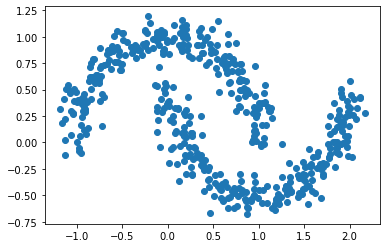

In [610]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

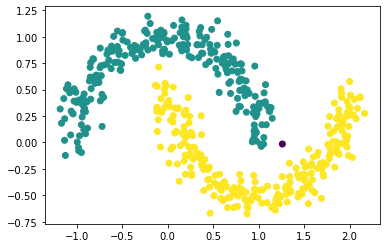

In [613]:
clusters = dbscan(eps=0.18, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()


Референс:

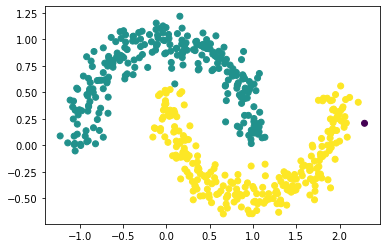

In [354]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()


> Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):



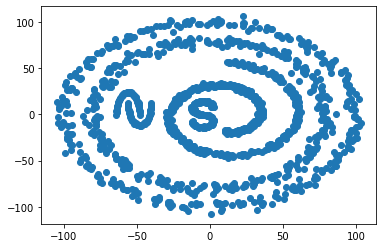

In [ ]:
# your code here


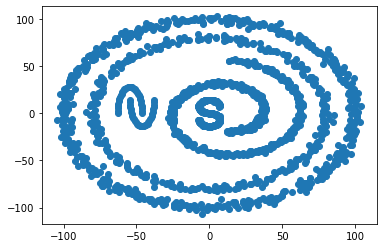

In [619]:
from sklearn import datasets
circle1, _ = datasets.make_circles(n_samples=(500, 0), noise=0.025, factor=0.35)
circle1 *= 100

circle2, _ = datasets.make_circles(n_samples=(300, 0), noise=0.025, factor=0.35)
circle2 *= 80

moons, _ = datasets.make_moons(n_samples=70)
moons[:, 0] = (moons[:, 0] - 6.5) * 0.3 
moons *= 28

s_curve, _ = datasets.make_s_curve(n_samples=300, noise=0.05)
s_curve = s_curve[:, ::2]
s_curve *= 7

roll, _ = datasets.make_swiss_roll(n_samples=500, noise=0.3)
roll = roll[:, ::2]
roll *= 4
roll[:, 0] += 12
X = np.concatenate((circle1, circle2, moons, s_curve, roll),axis=0)

plt.scatter(X[:,0], X[:,1])
plt.show()

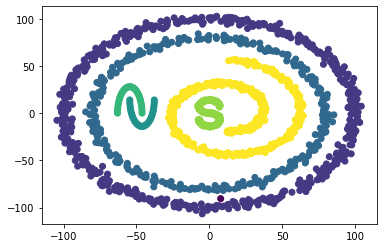

In [620]:
clusters = dbscan(eps=7, min_samples=3).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Или хотя бы что-нибудь такое: 

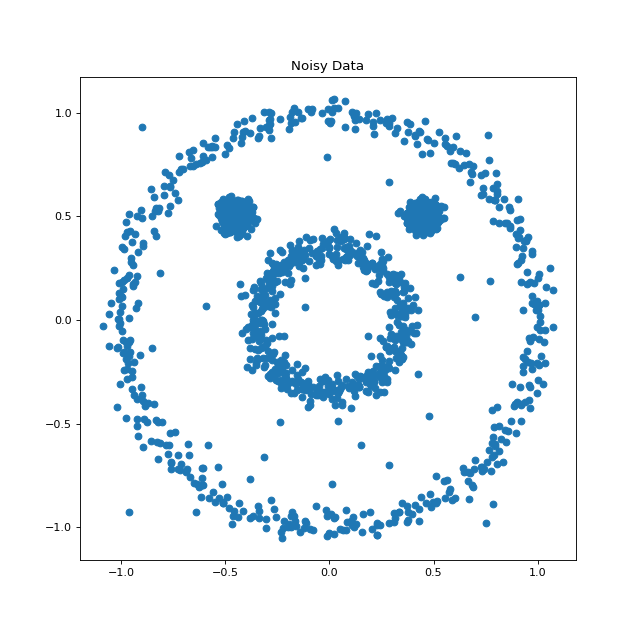

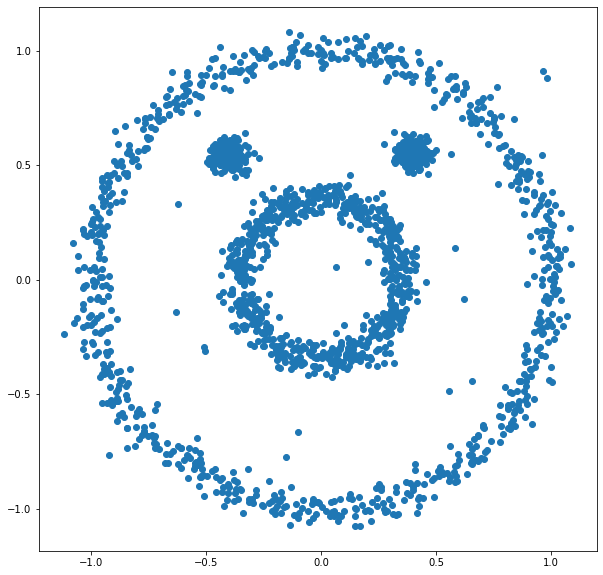

In [625]:
circles, _ = datasets.make_circles(n_samples=(800, 700), noise=0.04, factor=0.35)
blobs, _ = datasets.make_blobs(n_samples=500, centers=((0.4, 0.55), (-0.4, 0.55)), cluster_std=0.035)
random_dots = np.random.rand(30, 2) * 2 - 1
X = np.concatenate((circles, blobs, random_dots),axis=0)

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(X[:,0], X[:,1])
plt.show()

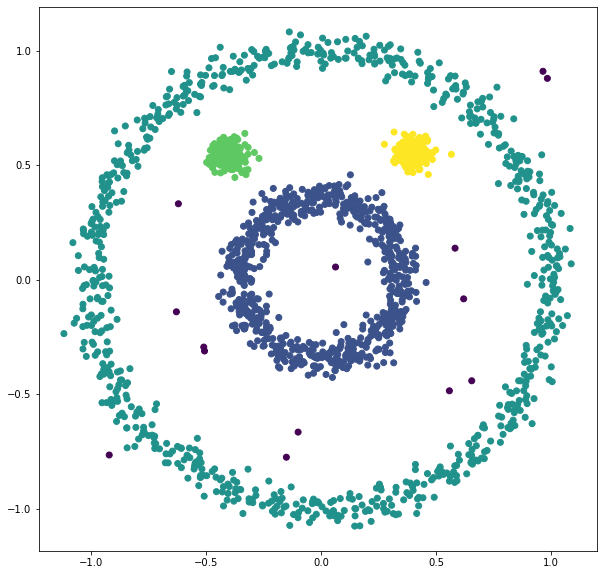

<Figure size 720x1440 with 0 Axes>

In [627]:
clusters = dbscan(eps=0.08, min_samples=3).fit_predict(X)
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.figure(figsize=(10,20))
plt.show()


> Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:



In [614]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 9.3 ms, sys: 11 µs, total: 9.31 ms
Wall time: 7.72 ms


In [615]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 4.35 s, sys: 0 ns, total: 4.35 s
Wall time: 4.35 s


## Применяем DBSCAN (3 балла)

__[1.5 балла]__ Возьмите колонки `Distance` и `DepTime` (из датасета о задержках самолётов). Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло? 

86


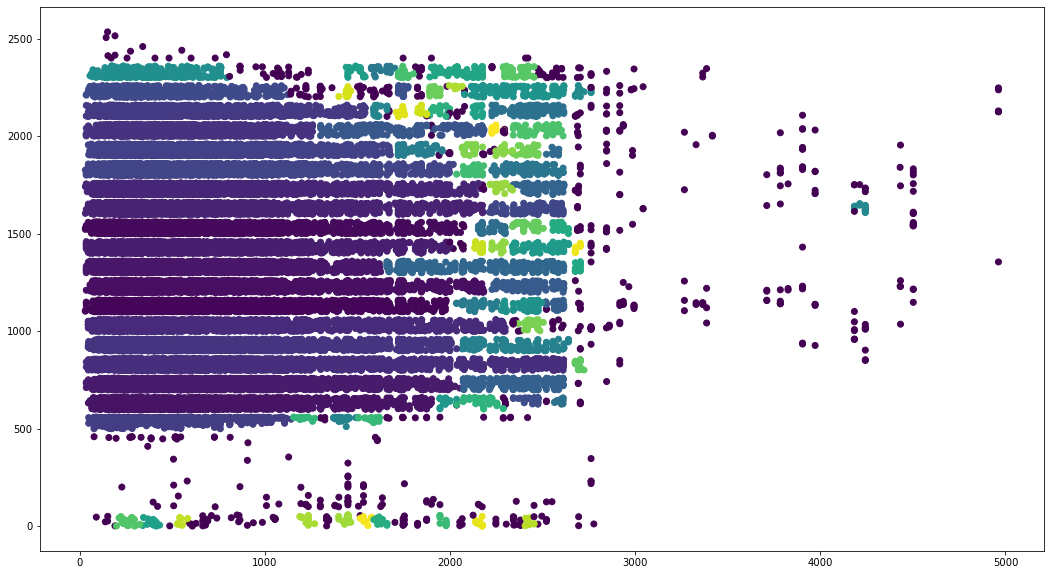

<Figure size 720x1440 with 0 Axes>

In [29]:
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt

clusters = DBSCAN(eps=40, min_samples=10).fit_predict(X_train_part)
print(len(set(clusters)))
fig, ax = plt.subplots(figsize=(18, 10))
plt.scatter(X_train_part[:,0], X_train_part[:,1], c=clusters)
plt.figure(figsize=(10,20))
plt.show()

Попробуйте перебрать параметры `eps` и `min_samples` по решётке и нарисовать для каждой пары облако рассеивания. При каких параметрах шумовых точек оказывается больше всего? Почему так происходит? 

__Ответ:__ При min_samples = 35 и epsilon = 5 шум составляет 70000, так как в окрестности с epsilon=5 нигде не находится 35 объектов одновременно и получается что каждая точка шумовая

min_samples=5
epsilon=5
cluster=2265
noise=18936


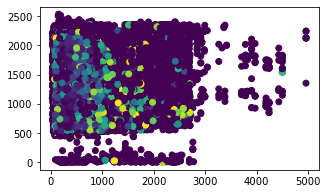

<Figure size 720x1440 with 0 Axes>

min_samples=10
epsilon=5
cluster=1077
noise=44187


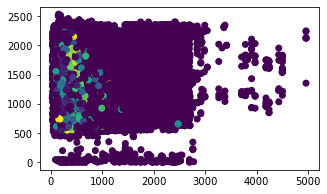

<Figure size 720x1440 with 0 Axes>

min_samples=15
epsilon=5
cluster=335
noise=61869


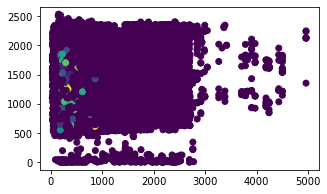

<Figure size 720x1440 with 0 Axes>

min_samples=20
epsilon=5
cluster=76
noise=68074


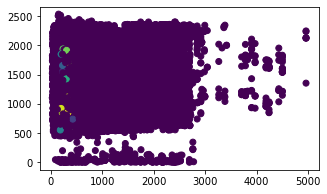

<Figure size 720x1440 with 0 Axes>

min_samples=25
epsilon=5
cluster=8
noise=69791


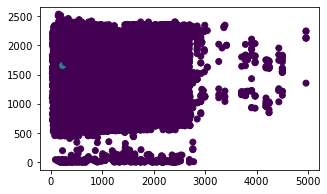

<Figure size 720x1440 with 0 Axes>

min_samples=30
epsilon=5
cluster=3
noise=69940


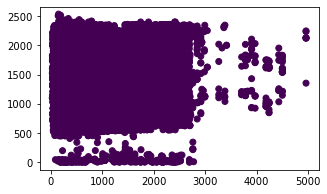

<Figure size 720x1440 with 0 Axes>

min_samples=35
epsilon=5
cluster=1
noise=70000


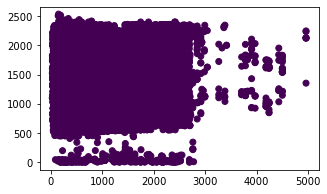

<Figure size 720x1440 with 0 Axes>

min_samples=40
epsilon=5
cluster=1
noise=70000


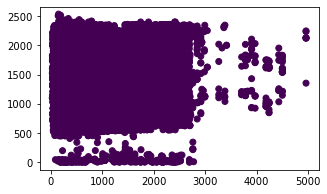

<Figure size 720x1440 with 0 Axes>

min_samples=45
epsilon=5
cluster=1
noise=70000


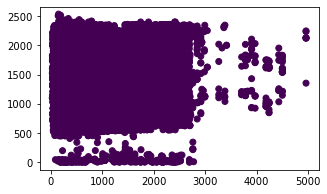

<Figure size 720x1440 with 0 Axes>

min_samples=5
epsilon=15
cluster=477
noise=2250


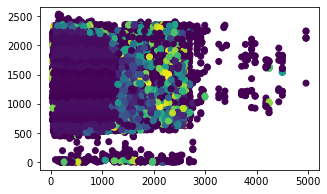

<Figure size 720x1440 with 0 Axes>

min_samples=10
epsilon=15
cluster=272
noise=5602


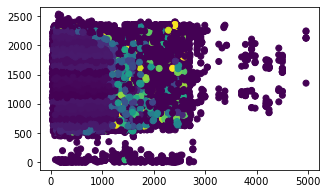

<Figure size 720x1440 with 0 Axes>

min_samples=15
epsilon=15
cluster=171
noise=9094


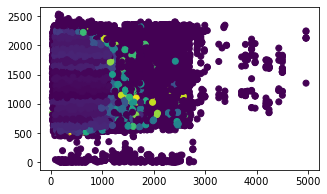

<Figure size 720x1440 with 0 Axes>

min_samples=20
epsilon=15
cluster=116
noise=11898


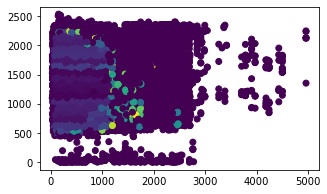

<Figure size 720x1440 with 0 Axes>

min_samples=25
epsilon=15
cluster=121
noise=14577


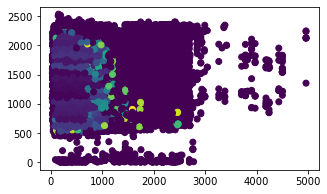

<Figure size 720x1440 with 0 Axes>

min_samples=30
epsilon=15
cluster=138
noise=17872


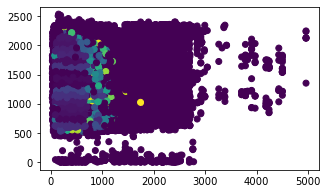

<Figure size 720x1440 with 0 Axes>

min_samples=35
epsilon=15
cluster=143
noise=21815


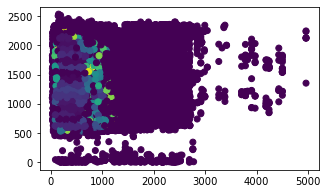

<Figure size 720x1440 with 0 Axes>

min_samples=40
epsilon=15
cluster=138
noise=26164


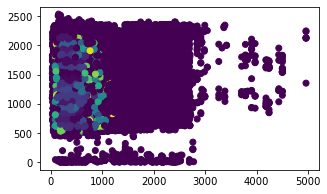

<Figure size 720x1440 with 0 Axes>

min_samples=45
epsilon=15
cluster=139
noise=31233


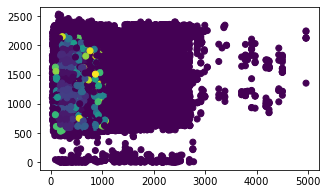

<Figure size 720x1440 with 0 Axes>

min_samples=5
epsilon=25
cluster=244
noise=666


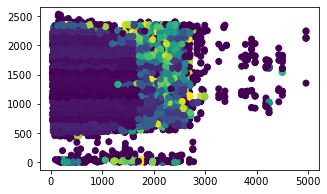

<Figure size 720x1440 with 0 Axes>

min_samples=10
epsilon=25
cluster=188
noise=1952


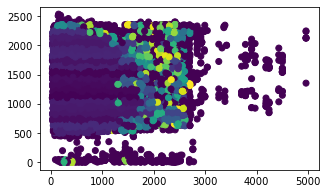

<Figure size 720x1440 with 0 Axes>

min_samples=15
epsilon=25
cluster=148
noise=3516


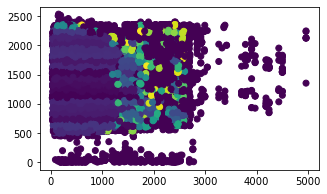

<Figure size 720x1440 with 0 Axes>

min_samples=20
epsilon=25
cluster=122
noise=5020


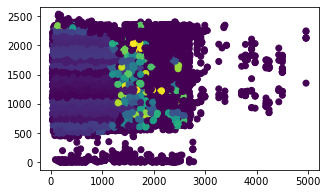

<Figure size 720x1440 with 0 Axes>

min_samples=25
epsilon=25
cluster=103
noise=6559


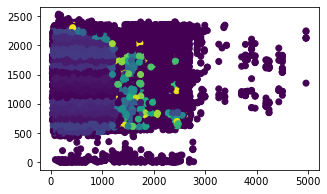

<Figure size 720x1440 with 0 Axes>

min_samples=30
epsilon=25
cluster=80
noise=8129


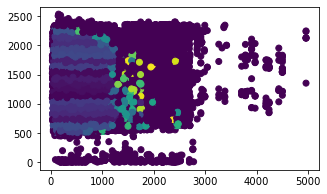

<Figure size 720x1440 with 0 Axes>

min_samples=35
epsilon=25
cluster=74
noise=9271


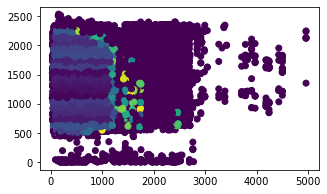

<Figure size 720x1440 with 0 Axes>

min_samples=40
epsilon=25
cluster=63
noise=10455


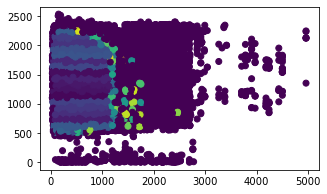

<Figure size 720x1440 with 0 Axes>

min_samples=45
epsilon=25
cluster=57
noise=11577


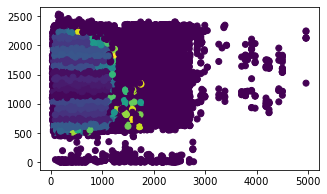

<Figure size 720x1440 with 0 Axes>

min_samples=5
epsilon=35
cluster=128
noise=409


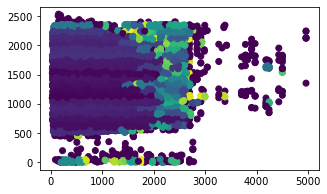

<Figure size 720x1440 with 0 Axes>

min_samples=10
epsilon=35
cluster=119
noise=844


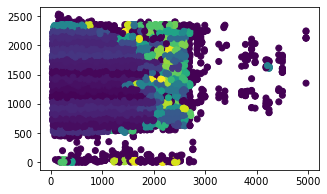

<Figure size 720x1440 with 0 Axes>

min_samples=15
epsilon=35
cluster=121
noise=1477


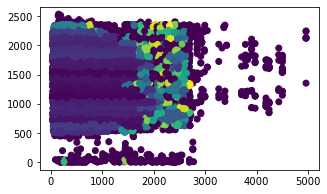

<Figure size 720x1440 with 0 Axes>

min_samples=20
epsilon=35
cluster=107
noise=2377


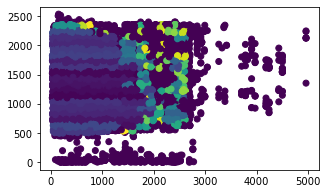

<Figure size 720x1440 with 0 Axes>

min_samples=25
epsilon=35
cluster=88
noise=3524


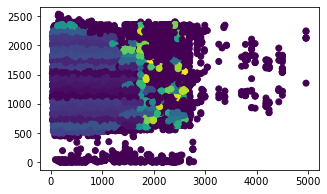

<Figure size 720x1440 with 0 Axes>

min_samples=30
epsilon=35
cluster=82
noise=4333


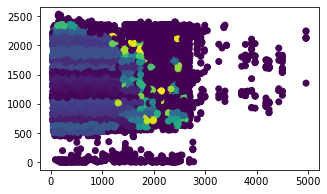

<Figure size 720x1440 with 0 Axes>

min_samples=35
epsilon=35
cluster=78
noise=5302


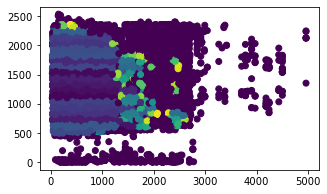

<Figure size 720x1440 with 0 Axes>

min_samples=40
epsilon=35
cluster=60
noise=6525


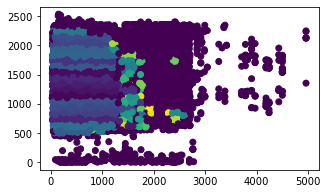

<Figure size 720x1440 with 0 Axes>

min_samples=45
epsilon=35
cluster=57
noise=7266


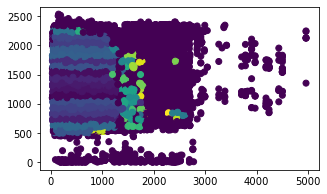

<Figure size 720x1440 with 0 Axes>

min_samples=5
epsilon=45
cluster=44
noise=287


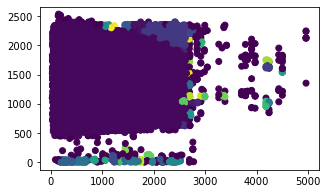

<Figure size 720x1440 with 0 Axes>

min_samples=10
epsilon=45
cluster=29
noise=528


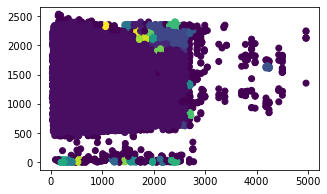

<Figure size 720x1440 with 0 Axes>

min_samples=15
epsilon=45
cluster=27
noise=886


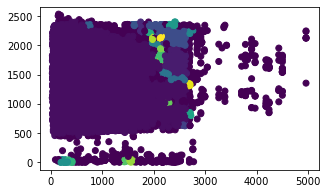

<Figure size 720x1440 with 0 Axes>

min_samples=20
epsilon=45
cluster=35
noise=1336


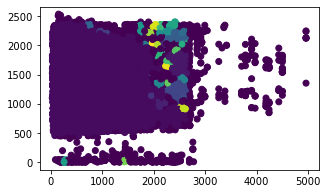

<Figure size 720x1440 with 0 Axes>

min_samples=25
epsilon=45
cluster=40
noise=2020


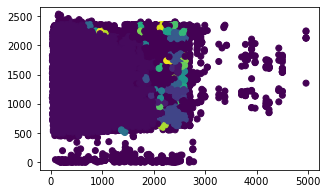

<Figure size 720x1440 with 0 Axes>

min_samples=30
epsilon=45
cluster=36
noise=2778


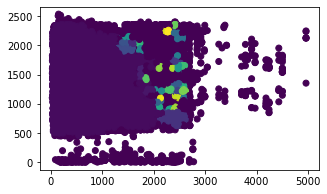

<Figure size 720x1440 with 0 Axes>

min_samples=35
epsilon=45
cluster=35
noise=3497


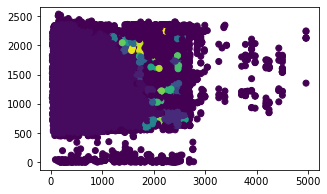

<Figure size 720x1440 with 0 Axes>

min_samples=40
epsilon=45
cluster=32
noise=4230


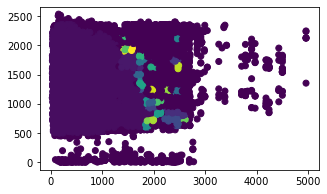

<Figure size 720x1440 with 0 Axes>

min_samples=45
epsilon=45
cluster=31
noise=4957


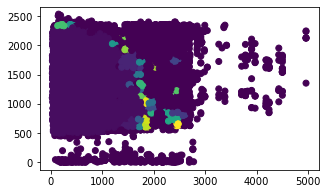

<Figure size 720x1440 with 0 Axes>

min_samples=5
epsilon=55
cluster=31
noise=222


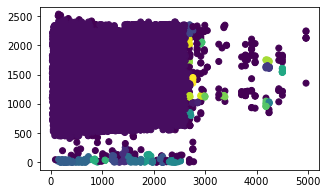

<Figure size 720x1440 with 0 Axes>

min_samples=10
epsilon=55
cluster=13
noise=384


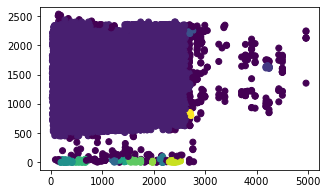

<Figure size 720x1440 with 0 Axes>

min_samples=15
epsilon=55
cluster=12
noise=553


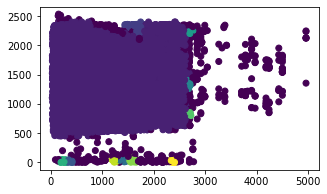

<Figure size 720x1440 with 0 Axes>

min_samples=20
epsilon=55
cluster=11
noise=818


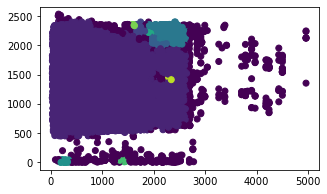

<Figure size 720x1440 with 0 Axes>

min_samples=25
epsilon=55
cluster=17
noise=1117


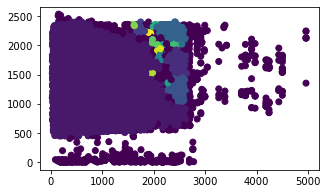

<Figure size 720x1440 with 0 Axes>

min_samples=30
epsilon=55
cluster=14
noise=1641


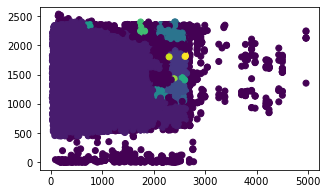

<Figure size 720x1440 with 0 Axes>

min_samples=35
epsilon=55
cluster=13
noise=2235


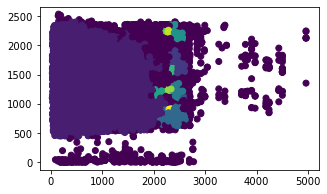

<Figure size 720x1440 with 0 Axes>

min_samples=40
epsilon=55
cluster=19
noise=2707


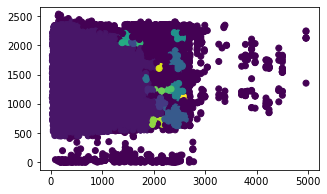

<Figure size 720x1440 with 0 Axes>

min_samples=45
epsilon=55
cluster=15
noise=3266


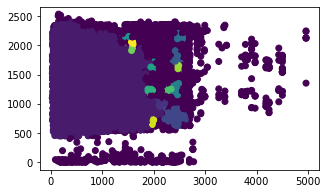

<Figure size 720x1440 with 0 Axes>

min_samples=5
epsilon=65
cluster=25
noise=165


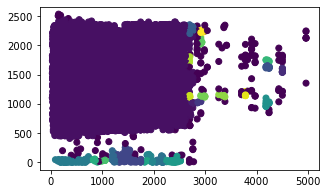

<Figure size 720x1440 with 0 Axes>

min_samples=10
epsilon=65
cluster=13
noise=308


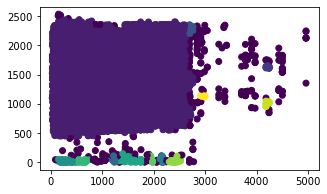

<Figure size 720x1440 with 0 Axes>

min_samples=15
epsilon=65
cluster=8
noise=427


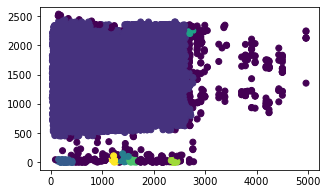

<Figure size 720x1440 with 0 Axes>

min_samples=20
epsilon=65
cluster=8
noise=529


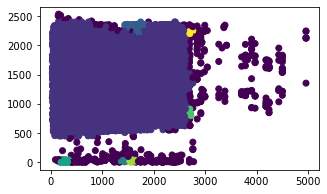

<Figure size 720x1440 with 0 Axes>

min_samples=25
epsilon=65
cluster=6
noise=702


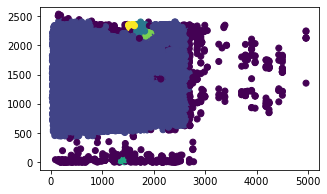

<Figure size 720x1440 with 0 Axes>

min_samples=30
epsilon=65
cluster=7
noise=876


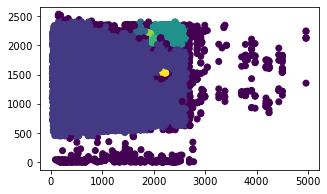

<Figure size 720x1440 with 0 Axes>

min_samples=35
epsilon=65
cluster=7
noise=1209


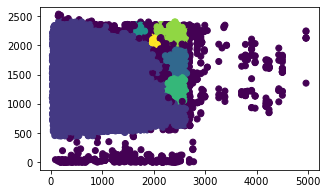

<Figure size 720x1440 with 0 Axes>

min_samples=40
epsilon=65
cluster=7
noise=1513


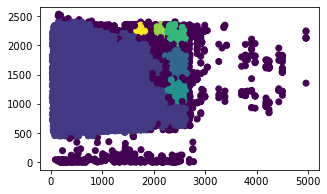

<Figure size 720x1440 with 0 Axes>

min_samples=45
epsilon=65
cluster=10
noise=1764


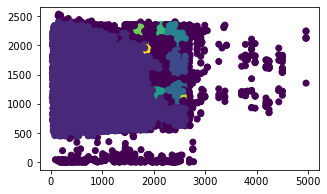

<Figure size 720x1440 with 0 Axes>

min_samples=5
epsilon=75
cluster=21
noise=99


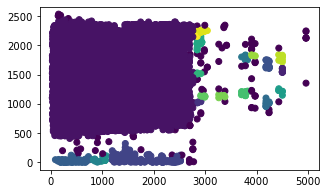

<Figure size 720x1440 with 0 Axes>

min_samples=10
epsilon=75
cluster=11
noise=235


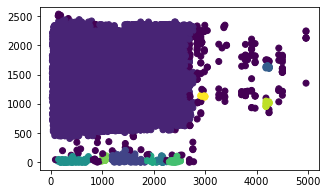

<Figure size 720x1440 with 0 Axes>

min_samples=15
epsilon=75
cluster=9
noise=313


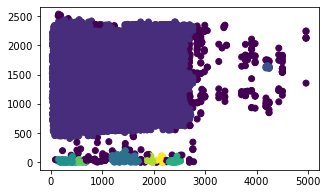

<Figure size 720x1440 with 0 Axes>

min_samples=20
epsilon=75
cluster=5
noise=445


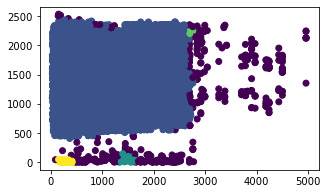

<Figure size 720x1440 with 0 Axes>

min_samples=25
epsilon=75
cluster=5
noise=516


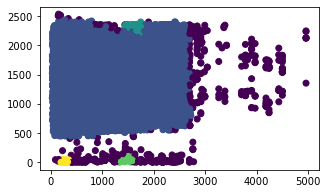

<Figure size 720x1440 with 0 Axes>

min_samples=30
epsilon=75
cluster=5
noise=614


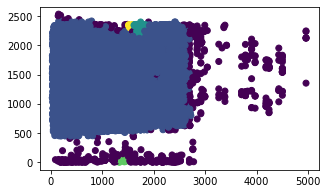

<Figure size 720x1440 with 0 Axes>

min_samples=35
epsilon=75
cluster=4
noise=742


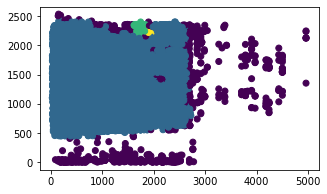

<Figure size 720x1440 with 0 Axes>

min_samples=40
epsilon=75
cluster=7
noise=918


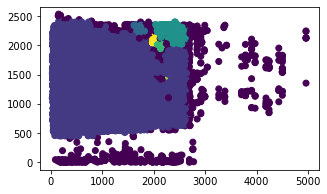

<Figure size 720x1440 with 0 Axes>

min_samples=45
epsilon=75
cluster=5
noise=1157


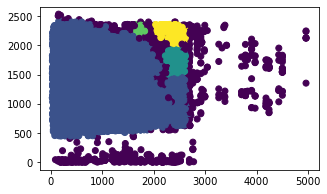

<Figure size 720x1440 with 0 Axes>

min_samples=5
epsilon=85
cluster=14
noise=75


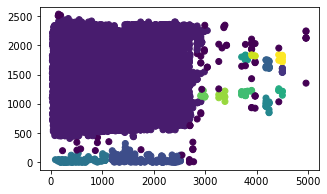

<Figure size 720x1440 with 0 Axes>

min_samples=10
epsilon=85
cluster=9
noise=168


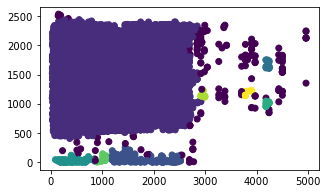

<Figure size 720x1440 with 0 Axes>

min_samples=15
epsilon=85
cluster=8
noise=261


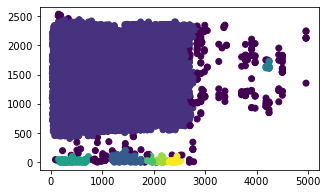

<Figure size 720x1440 with 0 Axes>

min_samples=20
epsilon=85
cluster=7
noise=338


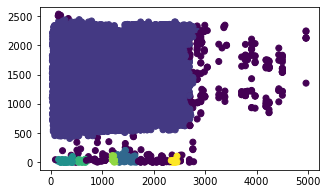

<Figure size 720x1440 with 0 Axes>

min_samples=25
epsilon=85
cluster=4
noise=420


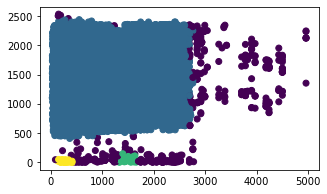

<Figure size 720x1440 with 0 Axes>

min_samples=30
epsilon=85
cluster=4
noise=470


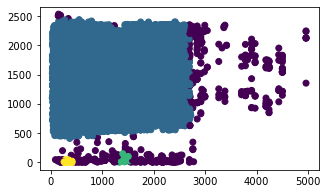

<Figure size 720x1440 with 0 Axes>

min_samples=35
epsilon=85
cluster=3
noise=575


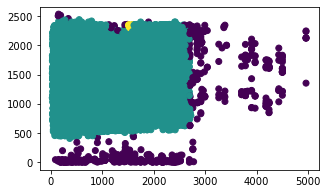

<Figure size 720x1440 with 0 Axes>

min_samples=40
epsilon=85
cluster=2
noise=615


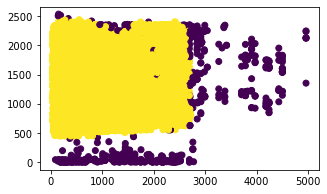

<Figure size 720x1440 with 0 Axes>

min_samples=45
epsilon=85
cluster=4
noise=703


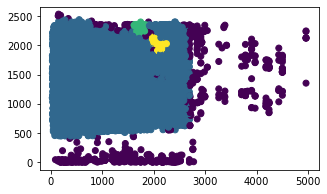

<Figure size 720x1440 with 0 Axes>

min_samples=5
epsilon=95
cluster=14
noise=60


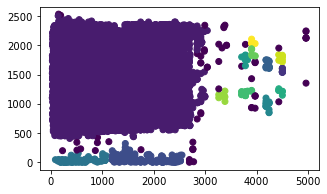

<Figure size 720x1440 with 0 Axes>

min_samples=10
epsilon=95
cluster=10
noise=119


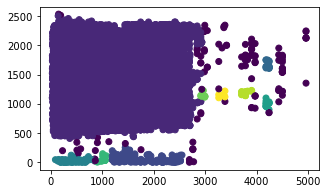

<Figure size 720x1440 with 0 Axes>

min_samples=15
epsilon=95
cluster=7
noise=213


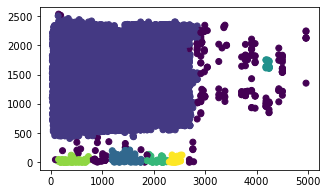

<Figure size 720x1440 with 0 Axes>

min_samples=20
epsilon=95
cluster=6
noise=299


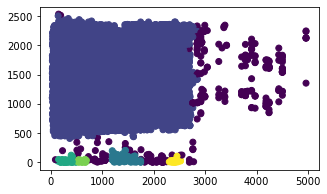

<Figure size 720x1440 with 0 Axes>

min_samples=25
epsilon=95
cluster=4
noise=373


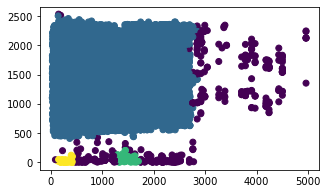

<Figure size 720x1440 with 0 Axes>

min_samples=30
epsilon=95
cluster=4
noise=405


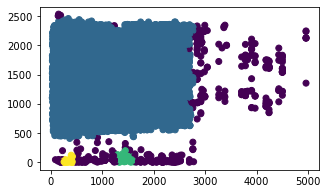

<Figure size 720x1440 with 0 Axes>

min_samples=35
epsilon=95
cluster=4
noise=447


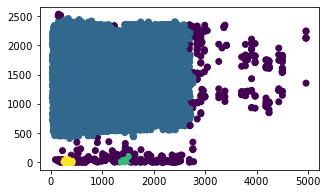

<Figure size 720x1440 with 0 Axes>

min_samples=40
epsilon=95
cluster=2
noise=531


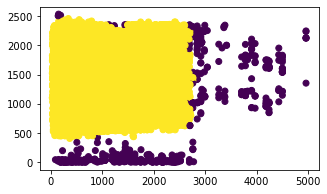

<Figure size 720x1440 with 0 Axes>

min_samples=45
epsilon=95
cluster=2
noise=542


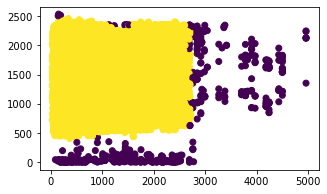

<Figure size 720x1440 with 0 Axes>

In [50]:
epsilons = range(5, 105, 10)
samples = range(5, 50, 5)

for eps in epsilons:
    for sample in samples:
        clusters = DBSCAN(eps=eps, min_samples=sample).fit_predict(X_train_part)
        res = np.array(clusters)
        print(f'min_samples={sample}\nepsilon={eps}\ncluster={len(set(clusters))}\nnoise={len(res[res == -1])}')
        fig, ax = plt.subplots(figsize=(5, 3))
        plt.scatter(X_train_part[:,0], X_train_part[:,1], c=clusters)
        plt.figure(figsize=(10,20))
        plt.show()

__[1.5 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

In [77]:
# По анализу сверху я выяснил что ~ лучшие значения для min_samples и epsilon -> 5 и 35 соответственно,
# однако я все таки возьму epsilon=10, min_samples=40 как в задании до этого, ибо мне кажется,
# что это разбиение более оптимально

features = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'clusterisation']
X_train = train.drop(labels='dep_delayed_15min', axis=1)
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
best_clusterisation = np.array([DBSCAN(eps=40, min_samples=10).fit_predict(X_train[['Distance', 'DepTime']])])
X_train['clusterisation'] = best_clusterisation.T

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)


cbc = CatBoostClassifier(task_type='CPU')
cbc.fit(X_train_part, y_train_part, cat_features=features)

Learning rate set to 0.063211
0:	learn: 0.6601475	total: 98.7ms	remaining: 1m 38s
1:	learn: 0.6323512	total: 146ms	remaining: 1m 12s
2:	learn: 0.6080686	total: 204ms	remaining: 1m 7s
3:	learn: 0.5880852	total: 256ms	remaining: 1m 3s
4:	learn: 0.5707896	total: 293ms	remaining: 58.4s
5:	learn: 0.5545326	total: 341ms	remaining: 56.5s
6:	learn: 0.5437061	total: 355ms	remaining: 50.4s
7:	learn: 0.5315243	total: 405ms	remaining: 50.3s
8:	learn: 0.5196342	total: 447ms	remaining: 49.3s
9:	learn: 0.5093945	total: 492ms	remaining: 48.7s
10:	learn: 0.5016582	total: 529ms	remaining: 47.6s
11:	learn: 0.4940037	total: 633ms	remaining: 52.1s
12:	learn: 0.4871955	total: 690ms	remaining: 52.4s
13:	learn: 0.4820888	total: 776ms	remaining: 54.7s
14:	learn: 0.4777546	total: 838ms	remaining: 55s
15:	learn: 0.4732126	total: 895ms	remaining: 55s
16:	learn: 0.4696143	total: 971ms	remaining: 56.1s
17:	learn: 0.4660948	total: 1.04s	remaining: 56.8s
18:	learn: 0.4632945	total: 1.11s	remaining: 57.6s
19:	learn: 0

163:	learn: 0.4051235	total: 11.1s	remaining: 56.6s
164:	learn: 0.4050488	total: 11.2s	remaining: 56.5s
165:	learn: 0.4049869	total: 11.2s	remaining: 56.4s
166:	learn: 0.4049576	total: 11.3s	remaining: 56.3s
167:	learn: 0.4048689	total: 11.4s	remaining: 56.2s
168:	learn: 0.4047933	total: 11.4s	remaining: 56.1s
169:	learn: 0.4047142	total: 11.5s	remaining: 55.9s
170:	learn: 0.4046815	total: 11.5s	remaining: 55.8s
171:	learn: 0.4045868	total: 11.5s	remaining: 55.6s
172:	learn: 0.4045137	total: 11.6s	remaining: 55.5s
173:	learn: 0.4044274	total: 11.7s	remaining: 55.3s
174:	learn: 0.4043456	total: 11.7s	remaining: 55.3s
175:	learn: 0.4042902	total: 11.8s	remaining: 55.2s
176:	learn: 0.4042518	total: 11.9s	remaining: 55.2s
177:	learn: 0.4041752	total: 12s	remaining: 55.2s
178:	learn: 0.4041085	total: 12s	remaining: 55.1s
179:	learn: 0.4039832	total: 12.1s	remaining: 55.1s
180:	learn: 0.4039052	total: 12.2s	remaining: 55s
181:	learn: 0.4038056	total: 12.2s	remaining: 55s
182:	learn: 0.403771

323:	learn: 0.3955973	total: 21.7s	remaining: 45.3s
324:	learn: 0.3955572	total: 21.8s	remaining: 45.3s
325:	learn: 0.3954856	total: 21.9s	remaining: 45.2s
326:	learn: 0.3953926	total: 21.9s	remaining: 45.2s
327:	learn: 0.3953129	total: 22s	remaining: 45.1s
328:	learn: 0.3952633	total: 22.1s	remaining: 45s
329:	learn: 0.3952463	total: 22.1s	remaining: 44.9s
330:	learn: 0.3951926	total: 22.2s	remaining: 44.9s
331:	learn: 0.3951426	total: 22.2s	remaining: 44.8s
332:	learn: 0.3951191	total: 22.3s	remaining: 44.7s
333:	learn: 0.3950928	total: 22.4s	remaining: 44.6s
334:	learn: 0.3950531	total: 22.4s	remaining: 44.5s
335:	learn: 0.3950159	total: 22.5s	remaining: 44.5s
336:	learn: 0.3949367	total: 22.6s	remaining: 44.5s
337:	learn: 0.3948964	total: 22.7s	remaining: 44.4s
338:	learn: 0.3948310	total: 22.7s	remaining: 44.3s
339:	learn: 0.3948205	total: 22.8s	remaining: 44.2s
340:	learn: 0.3948017	total: 22.8s	remaining: 44.1s
341:	learn: 0.3947584	total: 22.9s	remaining: 44s
342:	learn: 0.3947

483:	learn: 0.3891292	total: 32.4s	remaining: 34.5s
484:	learn: 0.3891126	total: 32.5s	remaining: 34.5s
485:	learn: 0.3890794	total: 32.5s	remaining: 34.4s
486:	learn: 0.3890645	total: 32.6s	remaining: 34.3s
487:	learn: 0.3890249	total: 32.7s	remaining: 34.3s
488:	learn: 0.3890024	total: 32.7s	remaining: 34.2s
489:	learn: 0.3889751	total: 32.8s	remaining: 34.1s
490:	learn: 0.3889662	total: 32.8s	remaining: 34s
491:	learn: 0.3888855	total: 32.9s	remaining: 34s
492:	learn: 0.3888582	total: 33s	remaining: 33.9s
493:	learn: 0.3888485	total: 33.1s	remaining: 33.9s
494:	learn: 0.3888328	total: 33.1s	remaining: 33.8s
495:	learn: 0.3888081	total: 33.2s	remaining: 33.8s
496:	learn: 0.3887478	total: 33.3s	remaining: 33.7s
497:	learn: 0.3886941	total: 33.4s	remaining: 33.7s
498:	learn: 0.3886773	total: 33.5s	remaining: 33.6s
499:	learn: 0.3886530	total: 33.5s	remaining: 33.5s
500:	learn: 0.3886223	total: 33.6s	remaining: 33.5s
501:	learn: 0.3885532	total: 33.7s	remaining: 33.4s
502:	learn: 0.3885

643:	learn: 0.3836321	total: 42.9s	remaining: 23.7s
644:	learn: 0.3836026	total: 43s	remaining: 23.6s
645:	learn: 0.3835667	total: 43s	remaining: 23.6s
646:	learn: 0.3835513	total: 43.1s	remaining: 23.5s
647:	learn: 0.3835304	total: 43.1s	remaining: 23.4s
648:	learn: 0.3834875	total: 43.2s	remaining: 23.4s
649:	learn: 0.3834030	total: 43.3s	remaining: 23.3s
650:	learn: 0.3833866	total: 43.3s	remaining: 23.2s
651:	learn: 0.3833555	total: 43.4s	remaining: 23.2s
652:	learn: 0.3833339	total: 43.4s	remaining: 23.1s
653:	learn: 0.3833088	total: 43.5s	remaining: 23s
654:	learn: 0.3832521	total: 43.6s	remaining: 22.9s
655:	learn: 0.3832090	total: 43.7s	remaining: 22.9s
656:	learn: 0.3831674	total: 43.7s	remaining: 22.8s
657:	learn: 0.3830922	total: 43.8s	remaining: 22.8s
658:	learn: 0.3830793	total: 43.9s	remaining: 22.7s
659:	learn: 0.3830593	total: 43.9s	remaining: 22.6s
660:	learn: 0.3830384	total: 44s	remaining: 22.6s
661:	learn: 0.3830233	total: 44s	remaining: 22.5s
662:	learn: 0.3829991	

804:	learn: 0.3783895	total: 53s	remaining: 12.8s
805:	learn: 0.3783442	total: 53.1s	remaining: 12.8s
806:	learn: 0.3782828	total: 53.2s	remaining: 12.7s
807:	learn: 0.3782205	total: 53.2s	remaining: 12.6s
808:	learn: 0.3782012	total: 53.3s	remaining: 12.6s
809:	learn: 0.3781746	total: 53.4s	remaining: 12.5s
810:	learn: 0.3781320	total: 53.4s	remaining: 12.4s
811:	learn: 0.3781076	total: 53.5s	remaining: 12.4s
812:	learn: 0.3780859	total: 53.6s	remaining: 12.3s
813:	learn: 0.3780599	total: 53.6s	remaining: 12.3s
814:	learn: 0.3779943	total: 53.7s	remaining: 12.2s
815:	learn: 0.3779811	total: 53.8s	remaining: 12.1s
816:	learn: 0.3779377	total: 53.8s	remaining: 12.1s
817:	learn: 0.3778898	total: 53.9s	remaining: 12s
818:	learn: 0.3778427	total: 54s	remaining: 11.9s
819:	learn: 0.3778117	total: 54s	remaining: 11.9s
820:	learn: 0.3777553	total: 54.1s	remaining: 11.8s
821:	learn: 0.3777346	total: 54.2s	remaining: 11.7s
822:	learn: 0.3777092	total: 54.2s	remaining: 11.7s
823:	learn: 0.377686

966:	learn: 0.3738844	total: 1m 3s	remaining: 2.17s
967:	learn: 0.3738454	total: 1m 3s	remaining: 2.11s
968:	learn: 0.3738106	total: 1m 3s	remaining: 2.04s
969:	learn: 0.3737816	total: 1m 3s	remaining: 1.98s
970:	learn: 0.3737666	total: 1m 4s	remaining: 1.91s
971:	learn: 0.3737538	total: 1m 4s	remaining: 1.85s
972:	learn: 0.3737407	total: 1m 4s	remaining: 1.78s
973:	learn: 0.3737221	total: 1m 4s	remaining: 1.72s
974:	learn: 0.3737123	total: 1m 4s	remaining: 1.65s
975:	learn: 0.3736689	total: 1m 4s	remaining: 1.58s
976:	learn: 0.3736563	total: 1m 4s	remaining: 1.52s
977:	learn: 0.3736280	total: 1m 4s	remaining: 1.45s
978:	learn: 0.3736113	total: 1m 4s	remaining: 1.39s
979:	learn: 0.3735749	total: 1m 4s	remaining: 1.32s
980:	learn: 0.3735587	total: 1m 4s	remaining: 1.25s
981:	learn: 0.3735471	total: 1m 4s	remaining: 1.19s
982:	learn: 0.3735037	total: 1m 4s	remaining: 1.12s
983:	learn: 0.3734812	total: 1m 4s	remaining: 1.06s
984:	learn: 0.3734558	total: 1m 5s	remaining: 991ms
985:	learn: 

In [78]:
roc_auc_score(y_train_part, cbc.predict_proba(X_train_part)[:, 1])

0.9290866708010875

__Ответ:__ Да, качество модели заметно улучшилось, это произошло, очевидно, из-за добавления нового параметра
'clusterisation' - он неплохо кластеризует объекты, что позволяет модели лучше справляться с задачей распределения по классам. Вес этого параметра точно выше среднего

# Небольшие подарочки

**+0.1 балла** за фотографию того, как вы проводите лето на открытом воздухе

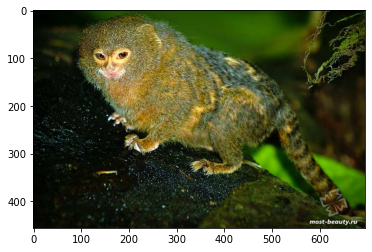

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("https://i.pinimg.com/originals/31/73/d7/3173d7517108d6f021b216b914c75d6f.png")
plt.imshow(image)
plt.show()

**+0.1 балла** за смешной мем по машинному обучению

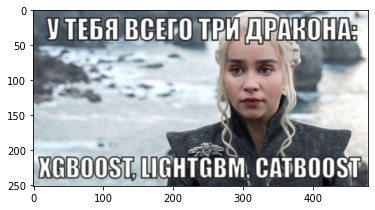

In [43]:
image = mpimg.imread('dany.png')
plt.imshow(image)
plt.show()

**+0.1 балла** за развернутый отзыв о курсе: ваших впечатлениях, сложностях и радостях, любимых темах и т.д.

In [ ]:
# Курс кайф реально, еще бы математики побольше и 
# разборов 'тумманных' тем, где говорят что это вот так работает то-то делает, а каким именно образом не указано,
# мат аппарат хочу и рекомендательные системы писать